# Прогнозирование цены биткоина

Обучающие данные - это ежедневные данные о цене биткоина за предыдущие полтора года.

Тестовые данные - 7 дней после окончания обучающих данных.

Установим библиотеку CatBoost

Отключим вывод предупреждений

In [1]:
import warnings
warnings.filterwarnings('ignore')

Импортируем необходимые библиотеки

In [2]:
# библиотеки для обработки и анализа структурированных данных
import pandas as pd
import numpy as np

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека статистических моделей
from statsmodels.tsa.seasonal import seasonal_decompose

# библиотека для машинного обучения на основе градиентного бустинга
from catboost import CatBoostRegressor

# библиотека моделей для машинного обучения
from sklearn.metrics import mean_absolute_error

Настройки визуализации

In [3]:
sns.set_theme()

FONT_SMALL_SIZE = 10
FONT_MEDIUM_SIZE = 12
FONT_BIGGER_SIZE = 15

plt.rc('font', size=FONT_SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=1)                  # line width
plt.rc('figure', figsize=(12, 4))             # size of the figure

## Формирование датасета

*последние 7 строк для теста содержат значения, скопированные с предыдущего дня*

Сформируем рабочий датасет

In [4]:
file_path = r'D:\__projects__\diploma\portfolios-optimization\data\BTCUSDT_hourly_data.csv'

df = pd.read_csv(
    file_path,
    parse_dates=['Open time'], 
    index_col='Open time'   
)

data = df.copy()

print('Total length:', len(data))

data = data.sort_index()

columns_to_keep_and_rename = {
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low',
    'Close': 'Price',
    'Volume': 'Vol.' 
}

data = data[list(columns_to_keep_and_rename.keys())]
data = data.rename(columns=columns_to_keep_and_rename)

data['Change %'] = data['Price'].pct_change() * 100
data['Change %'] = data['Change %'].map('{:.2f}%'.format)

display(data.head())

print("\nТипы данных в колонках:")
print(data.dtypes)

# И информацию о датафрейме
print("\nИнформация о датафрейме:")
data.info()

Total length: 37996


,Open,High,Low,Price,Vol.,Change %
Open time,,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,nan%
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,1.43%
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,-0.73%
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,0.29%
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,-0.20%



Типы данных в колонках:
Open        float64
High        float64
Low         float64
Price       float64
Vol.        float64
Change %     object
dtype: object

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37996 entries, 2021-01-01 00:00:00 to 2025-05-03 16:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      37996 non-null  float64
 1   High      37996 non-null  float64
 2   Low       37996 non-null  float64
 3   Price     37996 non-null  float64
 4   Vol.      37996 non-null  float64
 5   Change %  37996 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.0+ MB


Преобразуем значения столбцов в нужный формат

In [5]:
data['Change %'] = data['Change %'].apply(lambda x: float(x.replace('%', '')))

# Удаляем колонку 'Vol.', если она больше не нужна.
data = data.drop('Vol.', axis=1)

# Для проверки можно вывести типы данных и первые строки
print("\nТипы данных после изменений во второй ячейке:")
print(data.dtypes)
print("\nПервые 5 строк после изменений во второй ячейке:")
display(data.head())


Типы данных после изменений во второй ячейке:
Open        float64
High        float64
Low         float64
Price       float64
Change %    float64
dtype: object

Первые 5 строк после изменений во второй ячейке:


,Open,High,Low,Price,Change %
Open time,,,,,
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20


In [6]:
import pandas as pd
import json # Для обработки JSON-подобных строк

# Загрузка новостного датасета
news_file_path = r'D:\__projects__\diploma\portfolios-optimization\notebooks\news_data\btc\combined_btc_news.csv'
try:
    news_df = pd.read_csv(news_file_path)
except FileNotFoundError:
    print(f"Файл новостей не найден: {news_file_path}")
    # Реши, как обрабатывать эту ситуацию: остановить выполнение или продолжить без новостей
    news_df = pd.DataFrame() # Пустой DataFrame, чтобы код ниже не падал сразу

if not news_df.empty:
    # Преобразуем 'date_published' в datetime
    news_df['date_published'] = pd.to_datetime(news_df['date_published'])
    
    # Установим 'date_published' как индекс
    news_df.set_index('date_published', inplace=True)
    
    # Отсортируем по индексу (важно для дальнейших операций resample/rolling)
    news_df.sort_index(inplace=True)

    print("Новостной датасет загружен и базово обработан:")
    display(news_df.head(2))
    print(news_df.info())
else:
    print("Новостной датасет пуст или не загружен.")

Новостной датасет загружен и базово обработан:


,title,url,authors,summary,banner_image,source,category_within_source,source_domain,topics,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
date_published,,,,,,,,,,,,
2022-03-01 12:58:36,Geopolitical Risk Returns for Global Markets,https://www.nytimes.com/2022/03/01/business/de...,[],Investors are weighing the implications of Rus...,https://static01.nyt.com/images/2022/03/01/mul...,New York Times,Dealbook,www.nytimes.com,"[{'topic': 'Economy - Monetary', 'relevance_sc...",-0.138797,Neutral,"[{'ticker': 'NFLX', 'relevance_score': '0.0189..."
2022-03-02 02:32:56,"Asian shares slip, oil surges again as Russia ...",https://www.moneycontrol.com/news/business/mar...,[],"As global sanctions against Moscow tighten, th...",https://images.moneycontrol.com/static-mcnews/...,Money Control,Markets,www.moneycontrol.com,"[{'topic': 'Energy & Transportation', 'relevan...",-0.031243,Neutral,"[{'ticker': 'EQNR', 'relevance_score': '0.0639..."


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63355 entries, 2022-03-01 12:58:36 to 2025-05-02 05:57:38
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    63355 non-null  object 
 1   url                      63355 non-null  object 
 2   authors                  63355 non-null  object 
 3   summary                  63353 non-null  object 
 4   banner_image             60670 non-null  object 
 5   source                   63355 non-null  object 
 6   category_within_source   27173 non-null  object 
 7   source_domain            63355 non-null  object 
 8   topics                   63355 non-null  object 
 9   overall_sentiment_score  63355 non-null  float64
 10  overall_sentiment_label  63355 non-null  object 
 11  ticker_sentiment         63355 non-null  object 
dtypes: float64(1), object(11)
memory usage: 6.3+ MB
None


In [7]:
def extract_btc_sentiment(ticker_sentiment_str):
    if pd.isna(ticker_sentiment_str):
        return None
    try:
        # Строка может быть обернута в одинарные кавычки, json.loads ожидает двойные
        # Также уберем возможные проблемы с None/True/False, если они не стандартные JSON
        processed_str = ticker_sentiment_str.replace("'", '"')
        # json.loads может не справиться с некоторыми форматами, eval более гибкий, но менее безопасный
        # Если уверены в источнике, можно использовать eval, но с осторожностью.
        # Для AlphaVantage, если это действительно список словарей, json.loads должен работать
        # после замены кавычек.
        
        # Более безопасный способ, если json.loads не работает напрямую
        # из-за формата, похожего на Python-список, а не строгий JSON:
        import ast
        tickers_list = ast.literal_eval(ticker_sentiment_str) # Используем ast.literal_eval для безопасности
        
        for ticker_info in tickers_list:
            if ticker_info.get('ticker') == 'CRYPTO:BTC':
                return float(ticker_info.get('ticker_sentiment_score', 0.0)) # Возвращаем 0.0 если нет score
        return None # BTC не найден в списке
    except (SyntaxError, ValueError, TypeError) as e:
        # print(f"Ошибка парсинга ticker_sentiment: {e} для строки: {ticker_sentiment_str[:100]}")
        return None # В случае ошибки парсинга

if not news_df.empty:
    news_df['btc_specific_sentiment'] = news_df['ticker_sentiment'].apply(extract_btc_sentiment)
    print("\nНовостной датасет с извлеченным BTC сентиментом:")
    display(news_df[['overall_sentiment_score', 'btc_specific_sentiment']].head())
    print(f"Количество новостей с BTC сентиментом: {news_df['btc_specific_sentiment'].notna().sum()} из {len(news_df)}")


Новостной датасет с извлеченным BTC сентиментом:


,overall_sentiment_score,btc_specific_sentiment
date_published,,
2022-03-01 12:58:36,-0.138797,-0.118125
2022-03-02 02:32:56,-0.031243,0.006883
2022-03-02 08:00:00,-0.174572,-0.009523
2022-03-02 10:00:25,-0.036470,0.001776
2022-03-02 11:00:26,0.034280,-0.052478


Количество новостей с BTC сентиментом: 63355 из 63355


In [8]:
if not news_df.empty:
    # Выбираем нужные числовые колонки для агрегации
    cols_to_aggregate = ['overall_sentiment_score', 'btc_specific_sentiment']
    
    # Создаем признак "количество новостей"
    news_df['news_count'] = 1 
    
    # Агрегируем до часовой частоты
    # .resample('H') - группирует по часам
    # .agg() - применяет функции агрегации
    hourly_news_aggregated = news_df.resample('H').agg(
        avg_overall_sentiment=('overall_sentiment_score', 'mean'),
        avg_btc_specific_sentiment=('btc_specific_sentiment', 'mean'),
        sum_news_count=('news_count', 'sum')
        # Можно добавить другие агрегации, например, min, max, std для сентимента
    )
    
    # Заполним NaN, которые появятся в часах без новостей.
    # Можно заполнить нулями (означает отсутствие новостей / нейтральный сентимент)
    # или использовать ffill/bfill, если это имеет смысл.
    hourly_news_aggregated.fillna(0, inplace=True) # Заполняем нулями, т.к. нет новостей = нет влияния/нейтрально
                                                 # Для sum_news_count 0 - логично.
                                                 # Для avg_sentiment 0 может означать нейтрально.

    print("\nАгрегированные часовые новостные данные:")
    display(hourly_news_aggregated.head())
else:
    hourly_news_aggregated = pd.DataFrame() # Пустой, если новостей не было


Агрегированные часовые новостные данные:


,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
date_published,,,
2022-03-01 12:00:00,-0.138797,-0.118125,1
2022-03-01 13:00:00,0.000000,0.000000,0
2022-03-01 14:00:00,0.000000,0.000000,0
2022-03-01 15:00:00,0.000000,0.000000,0
2022-03-01 16:00:00,0.000000,0.000000,0


In [9]:
# Убедимся, что индекс 'data' тоже DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

if not hourly_news_aggregated.empty:
    # Объединяем, используя левое соединение, чтобы сохранить все строки из 'data'
    data_with_news = data.merge(hourly_news_aggregated, left_index=True, right_index=True, how='left')
    
    # После merge, для часов в 'data', где не было соответствующих новостей в 'hourly_news_aggregated',
    # появятся NaN. Заполним их нулями (или другим подходящим значением).
    news_cols_in_merged = list(hourly_news_aggregated.columns)
    data_with_news[news_cols_in_merged] = data_with_news[news_cols_in_merged].fillna(0)
    
    print("\nФинальный датасет 'data_with_news' (первые строки):")
    display(data_with_news.head())
    print("\nХвостовые строки, чтобы проверить заполнение NaN:")
    display(data_with_news.tail())
    print(data_with_news.info())
else:
    print("Новостные данные не были добавлены, так как 'hourly_news_aggregated' пуст.")
    data_with_news = data.copy() # Работаем с исходными данными, если новостей нет

# Теперь data_with_news содержит исходные данные BTC и добавленные часовые новостные признаки.
# Этот data_with_news можно использовать для дальнейшей предобработки и обучения модели.


Финальный датасет 'data_with_news' (первые строки):


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,NaN,0.0,0.0,0.0
2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,1.43,0.0,0.0,0.0
2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,-0.73,0.0,0.0,0.0
2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,0.29,0.0,0.0,0.0
2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,-0.20,0.0,0.0,0.0



Хвостовые строки, чтобы проверить заполнение NaN:


,Open,High,Low,Price,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count
2025-05-03 13:00:00,96120.43,96330.00,96106.53,96330.00,0.22,0.0,0.0,0.0
2025-05-03 14:00:00,96329.99,96459.67,96292.63,96380.95,0.05,0.0,0.0,0.0
2025-05-03 15:00:00,96380.96,96509.44,96380.95,96390.32,0.01,0.0,0.0,0.0
2025-05-03 16:00:00,96418.68,96428.33,96330.50,96364.82,-0.03,0.0,0.0,0.0
2025-05-03 16:00:00,96418.68,96428.33,96330.50,96330.52,-0.04,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37996 entries, 2021-01-01 00:00:00 to 2025-05-03 16:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Open                        37996 non-null  float64
 1   High                        37996 non-null  float64
 2   Low                         37996 non-null  float64
 3   Price                       37996 non-null  float64
 4   Change %                    37995 non-null  float64
 5   avg_overall_sentiment       37996 non-null  float64
 6   avg_btc_specific_sentiment  37996 non-null  float64
 7   sum_news_count              37996 non-null  float64
dtypes: float64(8)
memory usage: 2.6 MB
None


In [10]:
data = data_with_news.copy()

Установим константы

Размер всего датасета: 37996 наблюдений
Размер обучающей выборки (data_train): 37828 наблюдений
Размер тестовой выборки (data_test): 168 наблюдений (7 дней)


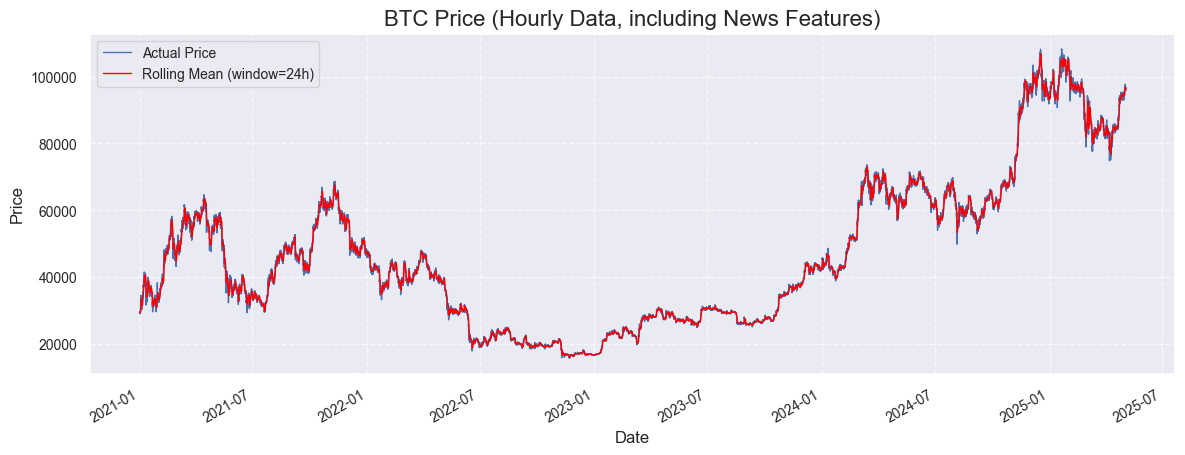


Выполняем сезонную декомпозицию с периодом 24 часов...


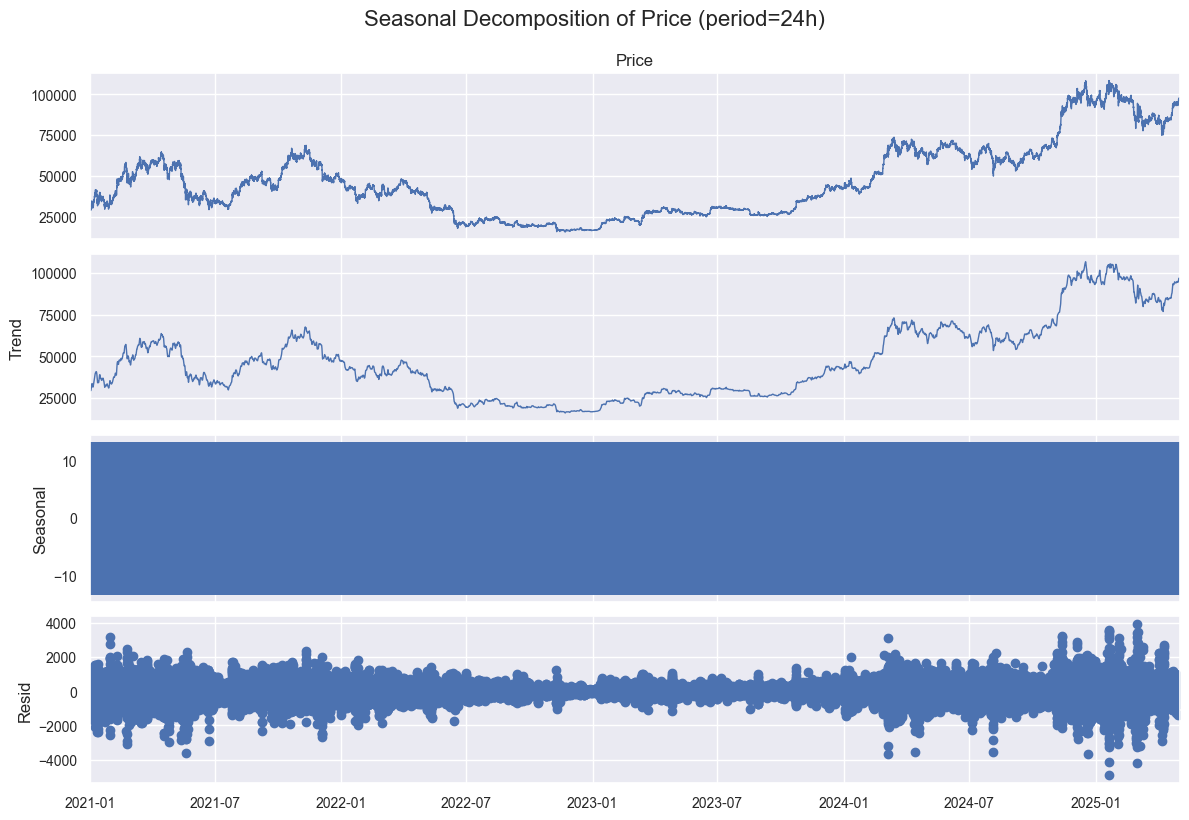

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd # Убедись, что pandas импортирован

# Убедимся, что 'data' существует и содержит TARGET
if 'data' not in locals() or not isinstance(data, pd.DataFrame):
    print("Ошибка: DataFrame 'data' не определен. Пожалуйста, загрузите или создайте его.")
    # Здесь можно либо остановить выполнение, либо создать dummy data для продолжения
    # exit()
    # Для примера, если data не существует, создадим пустой, чтобы код не падал
    data = pd.DataFrame(columns=['Price']) # Убедитесь, что TARGET соответствует этой колонке

TARGET = 'Price' # Целевой признак

if TARGET not in data.columns:
    print(f"Ошибка: Целевая колонка '{TARGET}' отсутствует в DataFrame 'data'.")
    # exit()
    # Для примера, если TARGET нет, добавим его с нулями
    if not data.empty:
        data[TARGET] = 0
    else: # Если и data пуст
        data = pd.DataFrame({TARGET: [0]*100}, index=pd.date_range(start='1/1/2023', periods=100, freq='H'))


# --- Параметры для анализа и разделения ---
HOURS_IN_DAY = 24
DAYS_FOR_TEST = 7
TEST_SIZE = DAYS_FOR_TEST * HOURS_IN_DAY # 168 часов

# RANDOM_SEED = 0 # Не используется в этой ячейке, но может быть определен глобально
# FOLDS_N = 10    # Не используется в этой ячейке

# --- Разделение на обучающую и тестовую выборки (для информации) ---
# Это разделение здесь в основном для информационного вывода и если бы мы дальше что-то делали
# с data_train/data_test в этой же ячейке. Графики строятся по всему 'data[TARGET]'.
if len(data) > TEST_SIZE:
    data_train = data[:-TEST_SIZE]
    data_test = data[-TEST_SIZE:]
    print(f"Размер всего датасета: {len(data)} наблюдений")
    print(f"Размер обучающей выборки (data_train): {len(data_train)} наблюдений")
    print(f"Размер тестовой выборки (data_test): {len(data_test)} наблюдений ({DAYS_FOR_TEST} дней)")
else:
    print(f"Предупреждение: Длина данных ({len(data)}) меньше или равна TEST_SIZE ({TEST_SIZE}). "
          f"Тестовая выборка будет пустой или неполной.")
    data_train = data.copy() # Весь датасет как обучающий
    data_test = pd.DataFrame(columns=data.columns, index=pd.Index([], dtype=data.index.dtype)) # Пустой тест


# --- Визуализация временного ряда цены и скользящего среднего ---
FONT_BIGGER_SIZE = 16 # Пример значения, если не определено глобально

plt.rc('figure', figsize=(14, 5)) # Сделал немного шире
plt.title(f'BTC {TARGET} (Hourly Data, including News Features)', fontsize=FONT_BIGGER_SIZE)
data[TARGET].plot(label='Actual Price')

rolling_window_hourly = 24 # Суточное скользящее среднее
r = data[TARGET].rolling(window=rolling_window_hourly)
rolling_mean = r.mean()
rolling_mean.plot(color='red', label=f'Rolling Mean (window={rolling_window_hourly}h)')
plt.legend()
plt.xlabel("Date")
plt.ylabel(TARGET)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Сезонная декомпозиция ---
decomposition_period_hourly = 24 # Дневная сезонность (24 часа)

# Убедимся, что в данных достаточно периодов для декомпозиции
if len(data[TARGET]) >= 2 * decomposition_period_hourly:
    print(f"\nВыполняем сезонную декомпозицию с периодом {decomposition_period_hourly} часов...")
    # Используем try-except, так как seasonal_decompose может выдать ошибку, если данные слишком короткие или специфичные
    try:
        sd = seasonal_decompose(data[TARGET], period=decomposition_period_hourly, model='additive')
        
        plt.rc('figure', figsize=(12, 8))
        fig_sd = sd.plot() # Сохраняем фигуру для возможной дальнейшей настройки
        fig_sd.suptitle(f'Seasonal Decomposition of {TARGET} (period={decomposition_period_hourly}h)', y=1.02, fontsize=FONT_BIGGER_SIZE)
        # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Иногда tight_layout может конфликтовать с suptitle, регулируем
        plt.subplots_adjust(top=0.94) # Даем место для suptitle
        plt.show()
    except ValueError as e_decompose:
        print(f"Ошибка при сезонной декомпозиции: {e_decompose}")
        print("Возможно, ряд слишком короткий или имеет недостаточно вариаций для выбранного периода.")
else:
    print(f"\nНедостаточно данных для сезонной декомпозиции с периодом {decomposition_period_hourly}.")
    print(f"Требуется как минимум {2 * decomposition_period_hourly} точек (2 полных периода), в наличии {len(data[TARGET])}.")

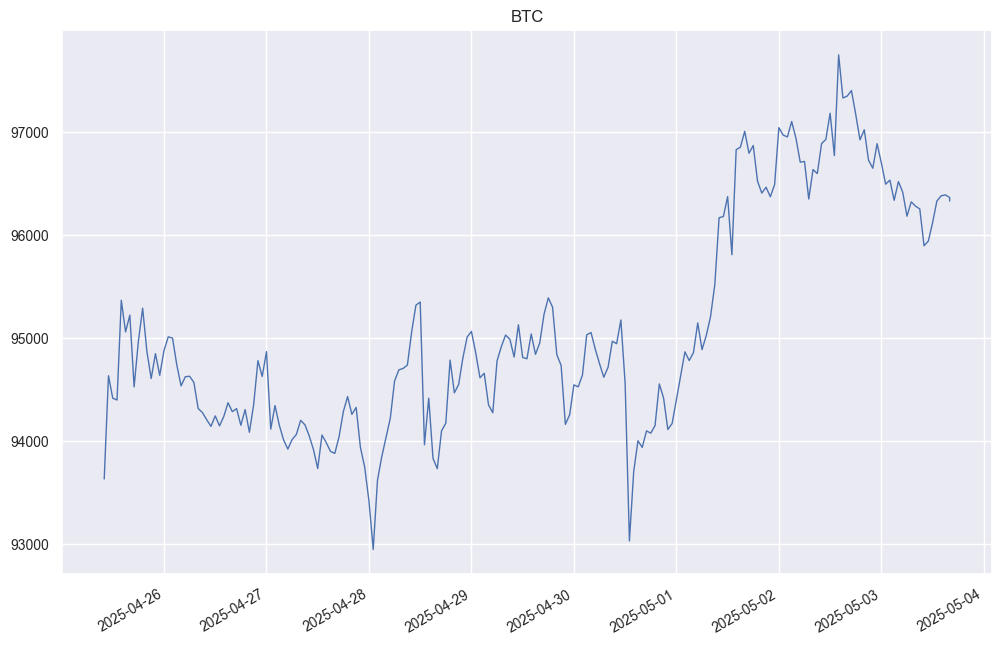

In [12]:
data[-200:][TARGET].plot()
plt.title('BTC')
plt.show()

## Функции подготовки данных и оптимизации модели

In [13]:
import pandas as pd
import numpy as np

# TARGET должна быть определена глобально, например:
# TARGET = 'Price'

# Список новостных колонок, которые мы добавили (укажи актуальные имена)
# Эти имена должны точно совпадать с тем, как они названы в data_with_news
NEWS_COLUMNS = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count']

# Функция code_mean остается без изменений, она универсальна
def code_mean(data_subset, cat_feature, real_feature):
    """Рассчитывает среднее значение real_feature для каждой категории cat_feature."""
    return dict(data_subset.groupby(cat_feature)[real_feature].mean())

def preprocess_data_hourly_no_leak(
    data_input: pd.DataFrame,
    target_col_name: str,
    lags_for_target: list = None,      # Лаги для целевой переменной
    lags_for_news: dict = None,        # Словарь: {'news_col_name': [lag1, lag2,...], ...}
                                       # или None, если лаги новостей не нужны
    test_size_hours: int = 7*24
):
    """
    Предобработка данных для часовых временных рядов с акцентом на предотвращение утечек,
    включая обработку новостных признаков.

    Args:
        data_input (pd.DataFrame): Входной DataFrame с DatetimeIndex, может содержать новостные колонки.
        target_col_name (str): Название целевой колонки.
        lags_for_target (list, optional): Список часов для создания лаговых признаков для target_col_name.
                                           Если None, используются дефолтные лаги.
        lags_for_news (dict, optional): Словарь, где ключи - имена новостных колонок,
                                        а значения - списки лагов для них.
                                        Пример: {'avg_overall_sentiment': [1, 6, 24]}
                                        Если None, лаги для новостных признаков не создаются.
        test_size_hours (int): Размер тестовой выборки в часах.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    if not isinstance(data_input.index, pd.DatetimeIndex):
        raise ValueError("Индекс входных данных должен быть pd.DatetimeIndex.")

    data = data_input.copy()

    if lags_for_target is None:
        lags_for_target = [1, 2, 3, 6, 12, 24, 24*2, 24*3, 24*7] # Дефолтные лаги для TARGET

    # 1. Создаем лаговые признаки для TARGET
    for lag in lags_for_target:
        data[f"{target_col_name}_lag_{lag}h"] = data[target_col_name].shift(lag)

    # 1.1 Создаем лаговые признаки для новостных колонок (если указано)
    if lags_for_news:
        for news_col, news_lags_list in lags_for_news.items():
            if news_col in data.columns:
                for lag in news_lags_list:
                    data[f"{news_col}_lag_{lag}h"] = data[news_col].shift(lag)
            else:
                print(f"Предупреждение: Новостная колонка '{news_col}' для создания лагов не найдена в data_input.")

    # 2. Создаем временные признаки (календарные)
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofmonth'] = data.index.day
    data['month'] = data.index.month
    # data['weekofyear'] = data.index.isocalendar().week.astype(int)

    # Новостные признаки (NEWS_COLUMNS) уже должны быть в 'data', если они были добавлены.
    # Если какие-то из NEWS_COLUMNS отсутствуют, они просто не будут включены в X_train/X_test.
    # Мы не будем их специально здесь добавлять или удалять, просто убедимся, что они есть, если нужны.

    # 3. Удаляем строки с NaN (из-за лагов)
    data = data.dropna()
    
    if data.empty:
        raise ValueError("После создания лагов и удаления NaN не осталось данных. "
                         "Проверьте размер исходных данных и значения лагов.")

    # 4. Определяем индекс разделения на train/test ПОСЛЕ dropna
    if test_size_hours < 1:
        num_test_samples = int(len(data) * test_size_hours)
    else:
        num_test_samples = test_size_hours
    
    if num_test_samples >= len(data) or num_test_samples <= 0:
        print(f"Предупреждение: test_size_hours ({num_test_samples}) некорректен для длины данных ({len(data)}). "
              f"Вся выборка будет обучающей, тестовая - пустой.")
        split_idx_pos = len(data)
    else:
        split_idx_pos = len(data) - num_test_samples

    train_df = data.iloc[:split_idx_pos].copy()
    test_df = data.iloc[split_idx_pos:].copy()

    # 5. Кодирование средним для календарных признаков
    features_for_mean_encoding = ['hour', 'dayofweek', 'dayofmonth', 'month']
    # calculated_means = {} # Не используется вне функции в этой версии

    for feat_cat in features_for_mean_encoding:
        if feat_cat in train_df.columns:
            means = code_mean(train_df, feat_cat, target_col_name)
            # global_mean_target_train_for_feat = train_df[target_col_name].mean() # старая версия
            # Более робастное вычисление среднего для заполнения, если категория новая
            # Если train_df пустой (например, из-за некорректного split_idx_pos)
            if train_df.empty:
                global_mean_fill_value = 0 # или np.nan, если предпочитаете
            else:
                global_mean_fill_value = train_df[target_col_name].mean()
                if pd.isna(global_mean_fill_value): # если все таргеты в трейне NaN
                    global_mean_fill_value = 0


            train_df[f'{feat_cat}_avg_{target_col_name}'] = train_df[feat_cat].map(means)
            train_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_fill_value, inplace=True)
            train_df.drop(feat_cat, axis=1, inplace=True)

            if feat_cat in test_df.columns:
                test_df[f'{feat_cat}_avg_{target_col_name}'] = test_df[feat_cat].map(means)
                test_df[f'{feat_cat}_avg_{target_col_name}'].fillna(global_mean_fill_value, inplace=True)
                test_df.drop(feat_cat, axis=1, inplace=True)
        # else: # Убрал предупреждение, т.к. признаки могут быть уже удалены или не созданы
            # print(f"Предупреждение: Категориальный признак '{feat_cat}' не найден для кодирования средним.")


    # 6. Формируем X_train, y_train, X_test, y_test
    # Колонки, которые НЕ являются TARGET и не являются исходными OHLVC (если они есть и их не надо в X)
    # или другими служебными, которые мы не хотим видеть в X.
    # В данной реализации все колонки, оставшиеся в train_df/test_df после drop(feat_cat) и не являющиеся target_col_name,
    # пойдут в X. Это включает исходные OHL, новостные колонки, все созданные лаги.

    if target_col_name in train_df.columns:
        X_train = train_df.drop(target_col_name, axis=1)
        y_train = train_df[target_col_name]
    else:
        X_train = train_df.copy()
        y_train = pd.Series(index=train_df.index, dtype=float, name=target_col_name)
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в train_df при формировании X/y.")

    if target_col_name in test_df.columns:
        X_test = test_df.drop(target_col_name, axis=1)
        y_test = test_df[target_col_name]
    else:
        X_test = test_df.copy()
        y_test = pd.Series(index=test_df.index, dtype=float, name=target_col_name)
        print(f"ПРЕДУПРЕЖДЕНИЕ: Целевая колонка '{target_col_name}' не найдена в test_df при формировании X/y.")

    print(f"Размер X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Размер X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    if X_test.empty or y_test.empty and num_test_samples > 0 : # Добавил условие про num_test_samples
        print("ПРЕДУПРЕЖДЕНИЕ: Тестовая выборка пуста, хотя ожидалась непустая! "
              "Проверьте test_size_hours и длину данных после создания лагов.")

    return X_train, X_test, y_train, y_test

In [14]:
# TARGET = 'Price' # Должна быть определена
# data = data_with_news.copy() # data теперь содержит и цены, и новости

# Определяем лаги для TARGET
target_lags = [1, 2, 3, 6, 12, 24, 48, 72, 168] # Пример

# Определяем лаги для новостных признаков (ключи - имена колонок из NEWS_COLUMNS)
news_lags_config = {
    'avg_overall_sentiment': [1, 6, 12, 24],
    'avg_btc_specific_sentiment': [1, 6, 12, 24],
    'sum_news_count': [1, 6, 12, 24]
    # Добавь сюда другие новостные колонки, если для них нужны лаги
}
# Если лаги новостей не нужны, передай lags_for_news=None

FINAL_TEST_SIZE_HOURS = 24*7 # Пример

try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # DataFrame с ценами и новостями
        target_col_name=TARGET,
        lags_for_target=target_lags,
        lags_for_news=news_lags_config, # Передаем конфигурацию лагов для новостей
        test_size_hours=FINAL_TEST_SIZE_HOURS
    )

    print("\nПример X_train (после добавления новостных признаков и их лагов):")
    if not X_train.empty: display(X_train.head())
    
    # Теперь X_train и X_test будут содержать:
    # - Исходные OHL (если они были в 'data' и не удалялись до вызова функции)
    # - Исходные новостные признаки (avg_overall_sentiment и т.д.)
    # - Лаги от TARGET (Price_lag_Xh)
    # - Лаги от новостных признаков (avg_overall_sentiment_lag_Xh и т.д.)
    # - Закодированные средним календарные признаки (hour_avg_Price и т.д.)

except ValueError as e:
    print(f"Ошибка при предобработке данных: {e}")
except Exception as e_gen:
    print(f"Непредвиденная ошибка при предобработке: {e_gen}")

Размер X_train: (37660, 32), y_train: (37660,)
Размер X_test: (168, 32), y_test: (168,)

Пример X_train (после добавления новостных признаков и их лагов):


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_1h,Price_lag_2h,Price_lag_3h,...,avg_btc_specific_sentiment_lag_12h,avg_btc_specific_sentiment_lag_24h,sum_news_count_lag_1h,sum_news_count_lag_6h,sum_news_count_lag_12h,sum_news_count_lag_24h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2021-01-08 00:00:00,39432.48,39699.87,38793.23,-1.62,0.0,0.0,0.0,39432.28,39665.92,39687.11,...,0.0,0.0,0.0,0.0,0.0,0.0,46238.417185,46261.223362,45945.506098,48442.578201
2021-01-08 01:00:00,38793.24,39000.00,37800.00,-0.29,0.0,0.0,0.0,38793.23,39432.28,39665.92,...,0.0,0.0,0.0,0.0,0.0,0.0,46236.476395,46261.223362,45945.506098,48442.578201
2021-01-08 02:00:00,38681.38,38692.83,36500.00,-3.88,0.0,0.0,0.0,38681.37,38793.23,39432.28,...,0.0,0.0,0.0,0.0,0.0,0.0,46220.763548,46261.223362,45945.506098,48442.578201
2021-01-08 03:00:00,37181.74,38460.13,37068.40,3.13,0.0,0.0,0.0,37181.74,38681.37,38793.23,...,0.0,0.0,0.0,0.0,0.0,0.0,46215.163635,46261.223362,45945.506098,48442.578201
2021-01-08 04:00:00,38347.11,38949.97,38155.61,0.84,0.0,0.0,0.0,38347.10,37181.74,38681.37,...,0.0,0.0,0.0,0.0,0.0,0.0,46220.737959,46261.223362,45945.506098,48442.578201


Функция кросс-валидации

In [15]:
# TARGET = 'Price'
# data = data_with_news.copy() # DataFrame с ценами и новостями
# model_for_cv = CatBoostRegressor(n_estimators=100, random_state=42, logging_level='Silent') # Пример модели
# VALIDATION_SIZE_HOURS_CV = 24 * 7
# NUM_FOLDS_CV = 3 # Меньше фолдов для быстрого теста

# Фиксированная конфигурация лагов для новостей на время оптимизации лагов TARGET
# Если не хотим лаги для новостей на этом этапе, ставим None
fixed_news_lags_for_cv = {
    'avg_overall_sentiment': [1, 6, 12, 24],
    'avg_btc_specific_sentiment': [1, 6, 12, 24],
    'sum_news_count': [6, 12, 24, 48] # Можно разные лаги для разных фичей
}
# fixed_news_lags_for_cv = None # Если не используем лаги новостей здесь

# Параметры для оптимизации лагов TARGET (start_lag, end_lag)
# Например, хотим попробовать лаги от 10 до 35 для TARGET
target_lag_params_to_try = (10, 35) # lag_start=10, lag_end=35 (т.е. лаги [10, ..., 34])

# cv_mae_score = cross_validation_hourly(
#     params_to_optimize=target_lag_params_to_try, # Оптимизируем лаги TARGET
#     full_data_for_cv=data,
#     target_col_name=TARGET,
#     model_instance=model_for_cv,
#     validation_fold_size_hours=VALIDATION_SIZE_HOURS_CV,
#     num_folds=NUM_FOLDS_CV,
#     fixed_target_lags_list=None, # Так как params_to_optimize задает лаги TARGET
#     news_lags_config=fixed_news_lags_for_cv # Передаем конфигурацию для новостных лагов
# )
# print(f"CV MAE для лагов TARGET {target_lag_params_to_try} (и новостных лагов): {cv_mae_score}")

# Если хотим использовать фиксированный список лагов для TARGET:
# fixed_target_lags = [10, 11, 12, 24, 48, 168]
# cv_mae_score_fixed = cross_validation_hourly(
#     params_to_optimize=None, # Не используется, так как fixed_target_lags_list задан
#     full_data_for_cv=data,
#     target_col_name=TARGET,
#     model_instance=model_for_cv,
#     validation_fold_size_hours=VALIDATION_SIZE_HOURS_CV,
#     num_folds=NUM_FOLDS_CV,
#     fixed_target_lags_list=fixed_target_lags,
#     news_lags_config=fixed_news_lags_for_cv
# )
# print(f"CV MAE для фиксированных лагов TARGET (и новостных лагов): {cv_mae_score_fixed}")

Функция поиска оптимальных параметров модели

In [16]:
import numpy as np
import pandas as pd # Убедимся, что pandas импортирован

# Предполагается, что cross_validation_hourly, TARGET, model_instance,
# VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS определены.

def model_optimize_lags(
    full_dataset: pd.DataFrame,
    target_col: str,
    model_to_use,
    validation_fold_hours: int,
    cv_folds_count: int,
    target_lag_params_ranges: tuple, # Диапазоны для lag_start и lag_end ТАРГЕТА
    fixed_news_lags_config: dict = None, # ФИКСИРОВАННАЯ конфигурация лагов для новостей
    verbose: bool = False
):
    """
    Оптимизирует параметры lag_start и lag_end для ЦЕЛЕВОЙ ПЕРЕМЕННОЙ,
    используя фиксированную конфигурацию лагов для новостных признаков.

    Args:
        full_dataset (pd.DataFrame): Полный DataFrame для CV (с новостями).
        target_col (str): Имя целевой колонки.
        model_to_use: Экземпляр модели.
        validation_fold_hours (int): Размер валидационного фолда.
        cv_folds_count (int): Количество фолдов CV.
        target_lag_params_ranges (tuple): ((start_min, start_max, start_step), (end_min, end_max, end_step))
                                          для лагов ЦЕЛЕВОЙ ПЕРЕМЕННОЙ.
        fixed_news_lags_config (dict, optional): Фиксированная конфигурация лагов для новостей.
                                                 Если None, лаги новостей не используются.
        verbose (bool): Если True, выводит прогресс.

    Returns:
        tuple: (best_mae, best_target_lags, target_lag_params_avg_mae, target_lag_params_grid_mae)
    """
    best_target_lags = (0, 0) # (lag_start_target, lag_end_target)
    best_mae = float('inf')

    target_lag_params_avg_mae_raw = {'start': {}, 'end': {}}
    target_lag_params_grid_mae = {} # {lag_end_target: {lag_start_target: mae}}

    start_range_def, end_range_def = target_lag_params_ranges

    for lag_e_target_candidate in range(end_range_def[0], end_range_def[1] + 1, end_range_def[2]):
        if lag_e_target_candidate not in target_lag_params_grid_mae:
            target_lag_params_grid_mae[lag_e_target_candidate] = {}

        for lag_s_target_candidate in range(start_range_def[0], start_range_def[1] + 1, start_range_def[2]):
            if lag_s_target_candidate >= lag_e_target_candidate:
                if verbose:
                    print(f"Пропуск (TARGET лаги): start={lag_s_target_candidate} >= end={lag_e_target_candidate}")
                target_lag_params_grid_mae[lag_e_target_candidate][lag_s_target_candidate] = float('nan')
                continue

            current_target_lags_to_optimize = (lag_s_target_candidate, lag_e_target_candidate)
            
            if verbose:
                print(f"Тестирование TARGET лагов: start={lag_s_target_candidate}, end={lag_e_target_candidate}")
                if fixed_news_lags_config:
                    print(f"  С фиксированными новостными лагами: {str(fixed_news_lags_config)[:70]}...")
                else:
                    print("  Без использования новостных лагов.")


            # Выполняем кросс-валидацию
            current_mae = cross_validation_hourly(
                params_to_optimize=current_target_lags_to_optimize, # Это (lag_s_target, lag_e_target)
                full_data_for_cv=full_dataset,
                target_col_name=target_col,
                model_instance=model_to_use,
                validation_fold_size_hours=validation_fold_hours,
                num_folds=cv_folds_count,
                fixed_target_lags_list=None, # т.к. params_to_optimize задает лаги TARGET
                news_lags_config=fixed_news_lags_config # Передаем фиксированную конфигурацию для новостей
            )

            if current_mae < best_mae:
                best_mae = current_mae
                best_target_lags = current_target_lags_to_optimize
                if verbose:
                    print(f"  Новая лучшая MAE: {best_mae:.4f} для TARGET лагов {best_target_lags}")

            target_lag_params_grid_mae[lag_e_target_candidate][lag_s_target_candidate] = current_mae

            if lag_s_target_candidate not in target_lag_params_avg_mae_raw['start']:
                target_lag_params_avg_mae_raw['start'][lag_s_target_candidate] = []
            target_lag_params_avg_mae_raw['start'][lag_s_target_candidate].append(current_mae)

            if lag_e_target_candidate not in target_lag_params_avg_mae_raw['end']:
                target_lag_params_avg_mae_raw['end'][lag_e_target_candidate] = []
            target_lag_params_avg_mae_raw['end'][lag_e_target_candidate].append(current_mae)

            if verbose:
                print(f"  TARGET лаги ({lag_s_target_candidate}-{lag_e_target_candidate}): MAE = {current_mae:.4f}")
    
    target_lag_params_avg_mae_final = {'start': {}, 'end': {}}
    for param_type, values_dict in target_lag_params_avg_mae_raw.items():
        for param_value, mae_list in values_dict.items():
            if mae_list:
                valid_mae_list = [m for m in mae_list if m != float('inf') and not np.isnan(m)]
                if valid_mae_list:
                    target_lag_params_avg_mae_final[param_type][param_value] = np.mean(valid_mae_list)
                else:
                    target_lag_params_avg_mae_final[param_type][param_value] = float('inf')
            else:
                target_lag_params_avg_mae_final[param_type][param_value] = float('inf')

    print(f"\nОптимизация TARGET лагов завершена.")
    print(f"Лучшее MAE: {best_mae:.4f}")
    print(f"Лучшие TARGET лаги (start, end): {best_target_lags}")
    if fixed_news_lags_config:
        print(f"При использовании фиксированных новостных лагов: {str(fixed_news_lags_config)[:100]}...")

    return best_mae, best_target_lags, target_lag_params_avg_mae_final, target_lag_params_grid_mae

In [17]:
# TARGET = 'Price'
# data_opt = data_with_news.copy() # Используем DataFrame с новостями
# model_for_opt_lags = CatBoostRegressor(n_estimators=100, random_state=42, logging_level='Silent')
# VALIDATION_SIZE_OPT = 24 * 7
# CV_FOLDS_OPT = 3

# Определяем диапазоны для оптимизации лагов ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
target_lag_ranges = (
    (1, 10, 2),    # (min_start, max_start, step_start) для TARGET лагов
    (15, 35, 5)   # (min_end, max_end, step_end) для TARGET лагов
)

# ЗАДАЕМ ФИКСИРОВАННУЮ конфигурацию лагов для новостей
# Эту конфигурацию можно выбрать на основе экспертных знаний,
# или предварительного анализа, или даже отдельного этапа оптимизации (более сложного).
news_lags_to_use_during_target_opt = {
    'avg_overall_sentiment': [1, 6, 24],
    'avg_btc_specific_sentiment': [1, 6, 24],
    'sum_news_count': [24, 48] # Например, только более длинные лаги для количества
}
# Или если не хотим использовать лаги новостей на этом этапе:
# news_lags_to_use_during_target_opt = None


# best_m, best_tl, avg_tl_stats, grid_tl_mae = model_optimize_lags(
#     full_dataset=data_opt,
#     target_col=TARGET,
#     model_to_use=model_for_opt_lags,
#     validation_fold_hours=VALIDATION_SIZE_OPT,
#     cv_folds_count=CV_FOLDS_OPT,
#     target_lag_params_ranges=target_lag_ranges,         # Диапазоны для лагов TARGET
#     fixed_news_lags_config=news_lags_to_use_during_target_opt, # ФИКСИРОВАННЫЕ лаги для новостей
#     verbose=True
# )

# print("\n--- Результаты оптимизации TARGET лагов ---")
# print(f"Лучший MAE: {best_m}")
# print(f"Лучшие параметры TARGET лагов (start, end): {best_tl}")
# if news_lags_to_use_during_target_opt:
#     print(f"Использовалась конфигурация новостных лагов: {news_lags_to_use_during_target_opt}")

# # Дальнейший анализ avg_tl_stats и grid_tl_mae как и раньше...

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import pandas as pd # Добавил импорт pandas

# Предполагается, что model, TARGET, preprocess_data_hourly_no_leak уже определены.

# Глобальные переменные (или передаются как аргументы в вызывающую функцию)
# TARGET = 'Price'
# model_instance = lgb.LGBMRegressor(...) # или CatBoostRegressor
# VALIDATION_FOLD_SIZE_HOURS = 7 * 24
# NUM_CV_FOLDS = 5

# Конфигурация лагов для новостей (может быть None или словарем)
# Эту конфигурацию нужно будет определить ДО вызова cross_validation_hourly,
# если мы хотим ее использовать.
# FIXED_NEWS_LAGS_CONFIG = {
#     'avg_overall_sentiment': [1, 6, 24],
#     'avg_btc_specific_sentiment': [1, 6, 24],
#     'sum_news_count': [1, 6, 24]
# }
# или FIXED_NEWS_LAGS_CONFIG = None

def generate_lags(lag_start, lag_end):
    """Генерирует список лагов от lag_start до lag_end-1."""
    if lag_start >= lag_end:
        return [lag_start] if lag_start > 0 else [1]
    return list(range(lag_start, lag_end))


def cross_validation_hourly(
    params_to_optimize, # Параметры для оптимизации лагов TARGET: (lag_s_target, lag_e_target)
    full_data_for_cv: pd.DataFrame,
    target_col_name: str,
    model_instance,
    validation_fold_size_hours: int,
    num_folds: int = 5,
    fixed_target_lags_list: list = None, # Если лаги TARGET фиксированы
    news_lags_config: dict = None      # Конфигурация лагов для новостных признаков
):
    """
    Выполняет кросс-валидацию для временных рядов, поддерживая лаги для TARGET и новостей.

    Args:
        params_to_optimize: Кортеж/список (lag_start_target, lag_end_target) для TARGET,
                            если fixed_target_lags_list is None.
        full_data_for_cv (pd.DataFrame): Полный DataFrame для CV (включая новостные признаки).
        target_col_name (str): Имя целевой колонки.
        model_instance: Экземпляр модели.
        validation_fold_size_hours (int): Размер валидационного фолда.
        num_folds (int): Количество фолдов.
        fixed_target_lags_list (list, optional): Фиксированный список лагов для TARGET.
        news_lags_config (dict, optional): Конфигурация лагов для новостных признаков
                                           (передается в preprocess_data_hourly_no_leak).
    Returns:
        float: Среднее значение MAE по всем фолдам.
    """

    if fixed_target_lags_list is None:
        if not (isinstance(params_to_optimize, (list, tuple)) and len(params_to_optimize) == 2):
            raise ValueError("params_to_optimize должен быть (lag_start_target, lag_end_target), "
                             "если fixed_target_lags_list не предоставлен.")
        lag_s_target, lag_e_target = map(int, params_to_optimize)
        if lag_s_target <= 0 or lag_e_target <= lag_s_target:
            print(f"Некорректные параметры лагов TARGET: start={lag_s_target}, end={lag_e_target}. Возврат inf MAE.")
            return float('inf')
        lags_for_target_processing = generate_lags(lag_s_target, lag_e_target)
        if not lags_for_target_processing:
             print(f"Список лагов TARGET пуст для start={lag_s_target}, end={lag_e_target}. Возврат inf MAE.")
             return float('inf')
    else:
        lags_for_target_processing = fixed_target_lags_list
        if not lags_for_target_processing: # Дополнительная проверка
            print(f"Предоставленный fixed_target_lags_list пуст. Возврат inf MAE.")
            return float('inf')


    scores = []
    
    # Определяем минимальную длину данных для фолда
    # Учитываем максимальный лаг из TARGET и из новостных признаков (если они есть)
    max_lag_target = max(lags_for_target_processing) if lags_for_target_processing else 0
    max_lag_news = 0
    if news_lags_config:
        for col_lags in news_lags_config.values():
            if col_lags: # Если список лагов для этой колонки не пуст
                max_lag_news = max(max_lag_news, max(col_lags))
    
    overall_max_lag = max(max_lag_target, max_lag_news)
    min_data_len_for_fold = overall_max_lag + validation_fold_size_hours + 1 # +1 для хотя бы одной строки обучения


    for i in range(num_folds):
        end_index_for_current_fold_data = len(full_data_for_cv) - i * validation_fold_size_hours
        current_fold_data = full_data_for_cv.iloc[:end_index_for_current_fold_data]

        if len(current_fold_data) < min_data_len_for_fold:
            print(f"Фолд {i+1}/{num_folds}: Недостаточно данных ({len(current_fold_data)} из мин. {min_data_len_for_fold}) "
                  f"для overall_max_lag={overall_max_lag} и валидации {validation_fold_size_hours}. Пропуск.")
            continue

        print(f"\nФолд {i+1}/{num_folds}:")
        print(f"  Данные для фолда: первые {len(current_fold_data)} строк.")
        print(f"  Лаги для TARGET: {lags_for_target_processing[:5]}... (всего {len(lags_for_target_processing)})")
        if news_lags_config:
             print(f"  Конфигурация лагов новостей: {str(news_lags_config)[:100]}...") # Выводим часть для краткости
        else:
             print("  Лаги новостей: не используются.")
        print(f"  Размер валидационного набора: {validation_fold_size_hours} часов")

        try:
            X_train, X_valid, y_train, y_valid = preprocess_data_hourly_no_leak(
                data_input=current_fold_data,
                target_col_name=target_col_name,
                lags_for_target=lags_for_target_processing, # Передаем лаги для TARGET
                lags_for_news=news_lags_config,          # Передаем конфигурацию лагов для новостей
                test_size_hours=validation_fold_size_hours
            )

            if X_train.empty or y_train.empty:
                print(f"  Фолд {i+1}/{num_folds}: Обучающая выборка пуста. Пропуск.")
                continue
            if X_valid.empty or y_valid.empty:
                print(f"  Фолд {i+1}/{num_folds}: Валидационная выборка пуста. Пропуск.")
                continue

            model_instance.fit(X_train, y_train,
                               eval_set=[(X_valid, y_valid)],
                               verbose=False) # или logging_level='Silent' для CatBoost

            y_pred = model_instance.predict(X_valid)
            mae = mean_absolute_error(y_valid, y_pred)
            scores.append(mae)
            print(f"  Фолд {i+1}/{num_folds}: MAE = {mae:.4f}")

        except ValueError as e:
            print(f"  ФоLD {i+1}/{num_folds}: Ошибка ValueError при обработке/обучении: {e}")
            # scores.append(float('inf')) # Можно штрафовать
            continue
        except Exception as e_general:
            print(f"  Фолд {i+1}/{num_folds}: Непредвиденная ошибка: {e_general}")
            import traceback
            traceback.print_exc() # Для подробной отладки
            continue

    if not scores:
        print("Кросс-валидация не дала ни одного результата. Проверьте параметры.")
        return float('inf')

    cv_score = np.mean(np.array(scores))
    print(f"\nСреднее MAE по {len(scores)} успешным фолдам: {cv_score:.4f}")
    return cv_score

## Оптимизация параметров модели

Установим общие параметры модели

In [19]:
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

# --- Предположения (должны быть определены ранее) ---
# TARGET, VALIDATION_FOLD_SIZE_HOURS, NUM_CV_FOLDS
# model_optimize_lags, cross_validation_hourly
# data (уже data_with_news)
# RANDOM_SEED

# --- Определение глобальных переменных (примеры, если не определены) ---
if 'RANDOM_SEED' not in locals(): RANDOM_SEED = 42
if 'TARGET' not in locals(): TARGET = 'Price'
if 'VALIDATION_FOLD_SIZE_HOURS' not in locals(): VALIDATION_FOLD_SIZE_HOURS = 24 * 7
if 'NUM_CV_FOLDS' not in locals(): NUM_CV_FOLDS = 3

# --- Создание экземпляра модели CatBoost ---
catboost_model_params = {
    'n_estimators': 900, # Для реальной оптимизации можно уменьшить для скорости
    'random_state': RANDOM_SEED,
    'logging_level': 'Silent',
    'loss_function': 'MAE',
    'eval_metric': 'MAE'
}
model_for_opt_lags = CatBoostRegressor(**catboost_model_params)

# --- Определение данных для оптимизации ---
# 'data' теперь должна быть data_with_news
if 'data' not in locals() or not isinstance(data, pd.DataFrame) or data.empty:
    print("Ошибка: DataFrame 'data' (ожидается data_with_news) не определен или пуст.")
    # Для примера создадим, но в реальном сценарии это должно быть подготовлено
    rng_opt = pd.date_range(start='2022-01-01', periods=1000, freq='H')
    # Добавим примерные новостные колонки, если их нет
    news_cols_example = ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count']
    example_news_data = {col: np.random.rand(1000) * 0.1 for col in news_cols_example}
    data = pd.DataFrame(index=rng_opt, data={TARGET: np.random.rand(1000) * 100 + 20000, **example_news_data})
    print("Создан пример DataFrame 'data' с новостными колонками.")

# --- Определение диапазонов для оптимизации лагов ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ---
target_lag_ranges_for_optimization = (
    (7, 10, 1),   # (min_start, max_start, step_start) для TARGET лагов
    (15, 35, 5)   # (min_end, max_end, step_end) для TARGET лагов
)

# --- ОПРЕДЕЛЕНИЕ ФИКСИРОВАННОЙ КОНФИГУРАЦИИ ЛАГОВ ДЛЯ НОВОСТЕЙ ---
# Вариант 1: Использовать определенный набор лагов для новостей
news_lags_to_use = {
    'avg_overall_sentiment': [1, 6, 12, 24],
    'avg_btc_specific_sentiment': [1, 6, 12, 24],
    'sum_news_count': [24, 48, 72] # Можно разные наборы для разных фичей
    # Убедись, что эти ключи ('avg_overall_sentiment' и т.д.) есть в твоем 'data'
}
# Проверим, что новостные колонки из конфигурации есть в данных
if news_lags_to_use:
    missing_news_cols_in_data = [col for col in news_lags_to_use if col not in data.columns]
    if missing_news_cols_in_data:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Следующие новостные колонки из 'news_lags_to_use' отсутствуют в 'data': {missing_news_cols_in_data}")
        print("  Лаги для этих колонок не будут созданы. Рассмотрите возможность их удаления из 'news_lags_to_use' или добавления в 'data'.")
        # Можно автоматически удалить отсутствующие ключи из news_lags_to_use
        # news_lags_to_use = {k: v for k, v in news_lags_to_use.items() if k in data.columns}


# Вариант 2: НЕ использовать лаги для новостей (только "сырые" новостные признаки)
# news_lags_to_use = None

print("Начало оптимизации параметров TARGET лагов...")
if news_lags_to_use:
    print(f"Будет использоваться следующая конфигурация для новостных лагов: {news_lags_to_use}")
else:
    print("Лаги для новостных признаков использоваться не будут (только их текущие значения).")

# Вызов обновленной функции model_optimize_lags
best_mae, best_target_lags_tuple, target_lag_avg_mae_stats, target_lag_grid_mae_vals = model_optimize_lags(
    full_dataset=data, # Теперь это data_with_news
    target_col=TARGET,
    model_to_use=model_for_opt_lags,
    validation_fold_hours=VALIDATION_FOLD_SIZE_HOURS,
    cv_folds_count=NUM_CV_FOLDS,
    target_lag_params_ranges=target_lag_ranges_for_optimization, # Диапазоны для лагов TARGET
    fixed_news_lags_config=news_lags_to_use, # <--- ДОБАВЛЕННЫЙ АРГУМЕНТ
    verbose=True
)

print("\n--- Результаты оптимизации TARGET лагов ---")
print(f"Лучшая MAE по кросс-валидации: {best_mae:.4f}")

best_target_lag_start, best_target_lag_end = best_target_lags_tuple
print(f"Лучшие параметры TARGET лагов (start, end) из оптимизации: ({best_target_lag_start}, {best_target_lag_end})")

# "Индивидуально оптимальные" TARGET лаги
if target_lag_avg_mae_stats.get('start'):
    valid_start_stats = {k: v for k, v in target_lag_avg_mae_stats['start'].items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        individual_opt_target_lag_start = int(min(valid_start_stats, key=valid_start_stats.get))
        print(f"Индивидуально оптимальный TARGET lag_start: {individual_opt_target_lag_start} (MAE: {valid_start_stats[individual_opt_target_lag_start]:.4f})")
    else: individual_opt_target_lag_start = None
else: individual_opt_target_lag_start = None

if target_lag_avg_mae_stats.get('end'):
    valid_end_stats = {k: v for k, v in target_lag_avg_mae_stats['end'].items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        individual_opt_target_lag_end = int(min(valid_end_stats, key=valid_end_stats.get))
        print(f"Индивидуально оптимальный TARGET lag_end: {individual_opt_target_lag_end} (MAE: {valid_end_stats[individual_opt_target_lag_end]:.4f})")
    else: individual_opt_target_lag_end = None
else: individual_opt_target_lag_end = None

# Для дальнейшего использования обычно берут лучшую пару TARGET лагов
final_target_lag_start = best_target_lag_start
final_target_lag_end = best_target_lag_end
print(f"\nВыбранные TARGET лаги для дальнейшего использования: lag_start={final_target_lag_start}, lag_end={final_target_lag_end}")
if news_lags_to_use:
    print(f"При этом использовалась следующая конфигурация новостных лагов: {news_lags_to_use}")

Начало оптимизации параметров TARGET лагов...
Будет использоваться следующая конфигурация для новостных лагов: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment': [1, 6, 12, 24], 'sum_news_count': [24, 48, 72]}
Тестирование TARGET лагов: start=7, end=15
  С фиксированными новостными лагами: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment'...

Фолд 1/3:
  Данные для фолда: первые 37996 строк.
  Лаги для TARGET: [7, 8, 9, 10, 11]... (всего 8)
  Конфигурация лагов новостей: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment': [1, 6, 12, 24], 'sum_news_co...
  Размер валидационного набора: 168 часов
Размер X_train: (37756, 30), y_train: (37756,)
Размер X_test: (168, 30), y_test: (168,)
  Фолд 1/3: MAE = 718.4778

Фолд 2/3:
  Данные для фолда: первые 37828 строк.
  Лаги для TARGET: [7, 8, 9, 10, 11]... (всего 8)
  Конфигурация лагов новостей: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment': [1, 6, 12, 24], '

Выведем диаграмму метрики для всех сочетаний параметров, а также среднюю величину метрики для отдельных значений подбираемых параметров

In [20]:
# ... (код вызова model_optimize_lags, как в предыдущем ответе) ...
# best_mae, best_target_lags_tuple, target_lag_avg_mae_stats, target_lag_grid_mae_vals = model_optimize_lags(
#     full_dataset=data, 
#     target_col=TARGET,
#     model_to_use=model_for_opt_lags,
#     validation_fold_hours=VALIDATION_FOLD_SIZE_HOURS,
#     cv_folds_count=NUM_CV_FOLDS,
#     target_lag_params_ranges=target_lag_ranges_for_optimization,
#     fixed_news_lags_config=news_lags_to_use, 
#     verbose=True
# )

# --- ПРИСВОЕНИЕ РЕЗУЛЬТАТОВ ПЕРЕМЕННЫМ ДЛЯ ВИЗУАЛИЗАЦИИ ---
lag_grid_mae_values = target_lag_grid_mae_vals    # Переименовываем для совместимости с кодом графика
lag_avg_mae_statistics = target_lag_avg_mae_stats # Переименовываем для совместимости

# После этого можно выполнять твой код для построения графиков
# import matplotlib.pyplot as plt
# import numpy as np
# ... (остальной код визуализации, который ты предоставил) ...

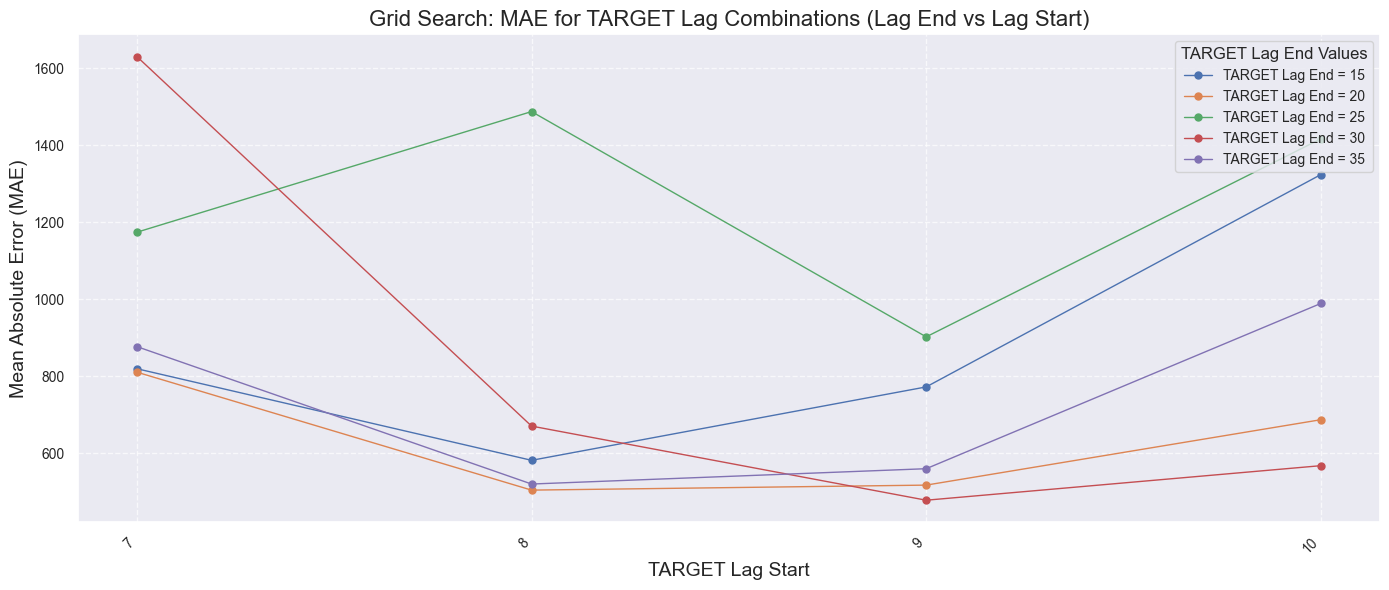

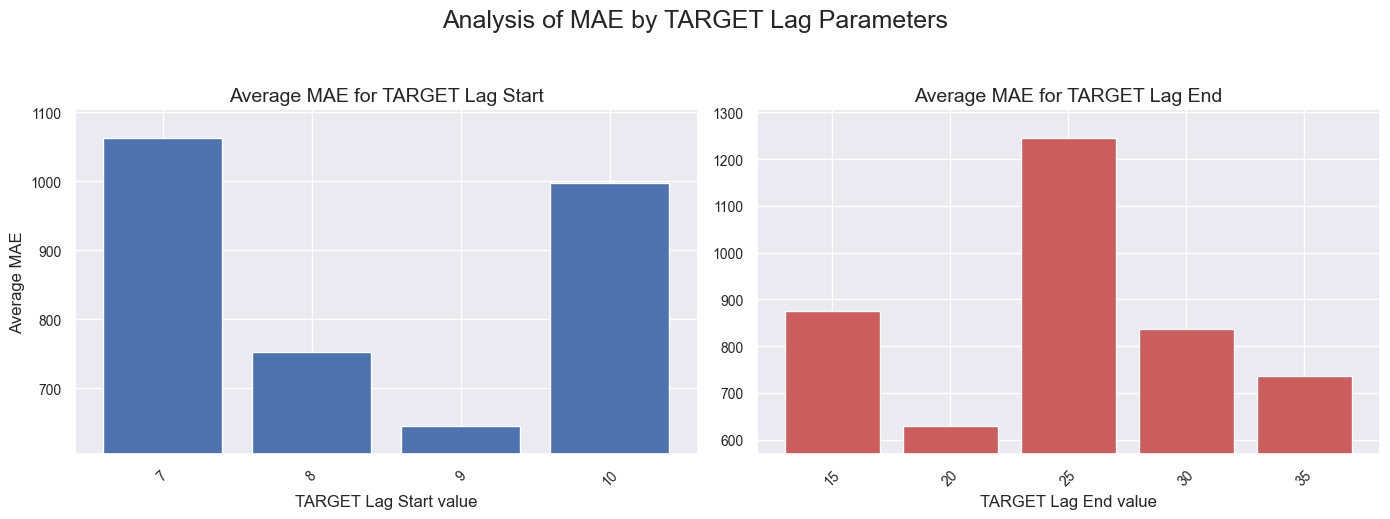

In [21]:
import matplotlib.pyplot as plt
import numpy as np # Для обработки NaN, если потребуется

# --- ПРЕДПОЛАГАЕМ, ЧТО ЭТИ ПЕРЕМЕННЫЕ УЖЕ ЕСТЬ ПОСЛЕ model_optimize_lags ---
# lag_grid_mae_values = target_lag_grid_mae_vals 
# lag_avg_mae_statistics = target_lag_avg_mae_stats
# ----------------------------------------------------------------------------

# --- График 1: Сетка параметров (Parameters grid) ---
plt.figure(figsize=(14, 6))
plt.title('Grid Search: MAE for TARGET Lag Combinations (Lag End vs Lag Start)', fontsize=16) # <--- Изменено

# ... (остальной код для графика 1 без изменений) ...
# Сортируем ключи lag_end для более упорядоченного графика и легенды
if not lag_grid_mae_values: # Проверка на пустой словарь
    print("Warning: lag_grid_mae_values is empty. Skipping grid plot.")
else:
    sorted_lag_end_keys = sorted(lag_grid_mae_values.keys())

    all_lag_start_keys = set()
    for lag_end_key in sorted_lag_end_keys:
        if lag_grid_mae_values[lag_end_key]: 
            all_lag_start_keys.update(lag_grid_mae_values[lag_end_key].keys())
    sorted_all_lag_start_keys = sorted(list(all_lag_start_keys))

    for lag_end_key in sorted_lag_end_keys:
        lag_start_to_mae_map = lag_grid_mae_values[lag_end_key]
        if not lag_start_to_mae_map: 
            continue
        plot_data_x = []
        plot_data_y = []
        temp_plot_data = sorted(lag_start_to_mae_map.items())
        for lag_start, mae in temp_plot_data:
            plot_data_x.append(lag_start)
            plot_data_y.append(mae)
        plt.plot(plot_data_x, plot_data_y, 'o-', label=f'TARGET Lag End = {lag_end_key}', markersize=5) # <--- Изменено

    if sorted_all_lag_start_keys: 
        plt.xticks(sorted_all_lag_start_keys, rotation=45, ha="right")
    plt.xlabel('TARGET Lag Start', fontsize=14) # <--- Изменено
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
    plt.legend(loc='upper right', title='TARGET Lag End Values') # <--- Изменено
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() 
    plt.show()


# --- График 2: Средние MAE для каждого значения параметра ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# График для lag_start
start_stats = lag_avg_mae_statistics.get('start', {})
if start_stats:
    valid_start_stats = {k: v for k, v in start_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_start_stats:
        sorted_start_keys = sorted(valid_start_stats.keys())
        start_values = [valid_start_stats[k] for k in sorted_start_keys]
        ax[0].bar([str(k) for k in sorted_start_keys], start_values)
        ax[0].set_title('Average MAE for TARGET Lag Start', fontsize=14) # <--- Изменено
        ax[0].set_xlabel('TARGET Lag Start value', fontsize=12) # <--- Изменено
        ax[0].set_ylabel('Average MAE', fontsize=12)
        ax[0].tick_params(axis='x', rotation=45)
        if start_values:
            min_val_s = min(start_values); max_val_s = max(start_values)
            padding_s = (max_val_s - min_val_s) * 0.1
            ax[0].set_ylim([min_val_s - padding_s if min_val_s > padding_s else 0 , max_val_s + padding_s])
    else:
        ax[0].text(0.5, 0.5, 'No valid data for Lag Start stats', ha='center', va='center')
        ax[0].set_title('Average MAE for TARGET Lag Start', fontsize=14) # <--- Изменено
else:
    ax[0].text(0.5, 0.5, 'No data for Lag Start stats', ha='center', va='center')
    ax[0].set_title('Average MAE for TARGET Lag Start', fontsize=14) # <--- Изменено

# График для lag_end
end_stats = lag_avg_mae_statistics.get('end', {})
if end_stats:
    valid_end_stats = {k: v for k, v in end_stats.items() if v != float('inf') and not np.isnan(v)}
    if valid_end_stats:
        sorted_end_keys = sorted(valid_end_stats.keys())
        end_values = [valid_end_stats[k] for k in sorted_end_keys]
        ax[1].bar([str(k) for k in sorted_end_keys], end_values, color='indianred')
        ax[1].set_title('Average MAE for TARGET Lag End', fontsize=14) # <--- Изменено
        ax[1].set_xlabel('TARGET Lag End value', fontsize=12) # <--- Изменено
        ax[1].tick_params(axis='x', rotation=45)
        if end_values:
            min_val_e = min(end_values); max_val_e = max(end_values)
            padding_e = (max_val_e - min_val_e) * 0.1
            ax[1].set_ylim([min_val_e - padding_e if min_val_e > padding_e else 0, max_val_e + padding_e])
    else:
        ax[1].text(0.5, 0.5, 'No valid data for Lag End stats', ha='center', va='center')
        ax[1].set_title('Average MAE for TARGET Lag End', fontsize=14) # <--- Изменено
else:
    ax[1].text(0.5, 0.5, 'No data for Lag End stats', ha='center', va='center')
    ax[1].set_title('Average MAE for TARGET Lag End', fontsize=14) # <--- Изменено

fig.suptitle('Analysis of MAE by TARGET Lag Parameters', fontsize=18, y=1.03) # <--- Изменено
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Перебор оптимальных сочетаний параметров

Рассчитаем и сохраним прогнозы модели на тестовых данных, перебирая ряд параметров с фиксированием значения оптимального параметра

In [22]:
import pandas as pd
import numpy as np

# --- Предположения (должны быть определены ранее) ---
# TARGET, data (data_with_news), model_for_opt_lags (обучаемая модель)
# individual_opt_target_lag_start, individual_opt_target_lag_end (из результатов оптимизации)
# preprocess_data_hourly_no_leak, generate_lags
# news_lags_to_use (фиксированная конфигурация новостных лагов, использованная при оптимизации)

# --- Вспомогательная функция (если не определена в этой ячейке) ---
if 'generate_lags' not in locals():
    def generate_lags(lag_start, lag_end):
        if lag_start >= lag_end: return [lag_start] if lag_start > 0 else [1]
        return list(range(lag_start, lag_end))

# --- Параметры ---
FINAL_TEST_SIZE_HOURS = 24 * 7 # Размер финального тестового набора

# Проверка наличия необходимых переменных
if 'TARGET' not in locals(): TARGET = 'Price' # Установим значение по умолчанию, если нужно
if 'data' not in locals():
    print("Ошибка: DataFrame 'data' (ожидается data_with_news) не определен.")
    exit()
if 'model_for_opt_lags' not in locals(): # Используем модель, которая была в ячейке оптимизации
    print("Ошибка: Экземпляр модели 'model_for_opt_lags' не определен.")
    exit()
if 'preprocess_data_hourly_no_leak' not in locals():
    print("Ошибка: Функция 'preprocess_data_hourly_no_leak' не определена.")
    exit()


# --- Проверка наличия оптимальных параметров TARGET лагов ---
# Используем те имена, которые были в результатах model_optimize_lags
if 'individual_opt_target_lag_start' not in locals() or individual_opt_target_lag_start is None:
    print("Ошибка: individual_opt_target_lag_start не определен. Запустите ячейку оптимизации.")
    # Для примера установим значение, если его нет, но в реальном коде лучше прерваться
    individual_opt_target_lag_start = 8 # Пример из твоего лога
    # exit() 
if 'individual_opt_target_lag_end' not in locals() or individual_opt_target_lag_end is None:
    print("Ошибка: individual_opt_target_lag_end не определен. Запустите ячейку оптимизации.")
    individual_opt_target_lag_end = 20 # Пример из твоего лога
    # exit()

# --- Конфигурация новостных лагов (должна быть такой же, как при оптимизации TARGET лагов) ---
if 'news_lags_to_use' not in locals():
    print("Предупреждение: 'news_lags_to_use' (конфигурация новостных лагов) не определена. "
          "Будет использовано None (без новостных лагов).")
    news_lags_to_use = None # Установим None, если не определено


print(f"--- Генерация прогнозов с фиксированным TARGET lag_start = {individual_opt_target_lag_start} ---")
print(f"Используемая конфигурация новостных лагов: {news_lags_to_use}")

for lag_end_candidate in range(15, 40, 5): # 15, 20, 25, 30, 35
    if individual_opt_target_lag_start >= lag_end_candidate:
        print(f"Пропуск: TARGET lag_start ({individual_opt_target_lag_start}) >= lag_end ({lag_end_candidate})")
        continue

    print(f"  Обработка для TARGET lag_end = {lag_end_candidate}...")
    try:
        target_lags_list = generate_lags(individual_opt_target_lag_start, lag_end_candidate)
        
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data,
            target_col_name=TARGET,
            lags_for_target=target_lags_list, # <--- Изменено имя аргумента
            lags_for_news=news_lags_to_use,   # <--- ДОБАВЛЕН АРГУМЕНТ
            test_size_hours=FINAL_TEST_SIZE_HOURS
        )

        if X_test.empty or y_test.empty:
            print(f"  Предупреждение: Тестовая выборка пуста для TARGET lag_end={lag_end_candidate}. Пропуск.")
            continue

        model_for_opt_lags.fit(X_train, y_train) # Используем model_for_opt_lags
        preds = model_for_opt_lags.predict(X_test)
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])
        filename = f'prediction_catboost_target_start_{individual_opt_target_lag_start}-end_{lag_end_candidate}_with_news.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
        print(f"  Ошибка при обработке TARGET lag_end={lag_end_candidate}: {e}")


print(f"\n--- Генерация прогнозов с фиксированным TARGET lag_end = {individual_opt_target_lag_end} ---")
print(f"Используемая конфигурация новостных лагов: {news_lags_to_use}")

for lag_start_candidate in range(7, 11, 1): # 7, 8, 9, 10
    if lag_start_candidate >= individual_opt_target_lag_end:
        print(f"Пропуск: TARGET lag_start ({lag_start_candidate}) >= lag_end ({individual_opt_target_lag_end})")
        continue

    print(f"  Обработка для TARGET lag_start = {lag_start_candidate}...")
    try:
        target_lags_list = generate_lags(lag_start_candidate, individual_opt_target_lag_end)
        
        X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
            data_input=data,
            target_col_name=TARGET,
            lags_for_target=target_lags_list, # <--- Изменено имя аргумента
            lags_for_news=news_lags_to_use,   # <--- ДОБАВЛЕН АРГУМЕНТ
            test_size_hours=FINAL_TEST_SIZE_HOURS
        )

        if X_test.empty or y_test.empty:
            print(f"  Предупреждение: Тестовая выборка пуста для TARGET lag_start={lag_start_candidate}. Пропуск.")
            continue

        model_for_opt_lags.fit(X_train, y_train) # Используем model_for_opt_lags
        preds = model_for_opt_lags.predict(X_test)
        X_result = pd.DataFrame(data=preds, index=y_test.index, columns=[TARGET])
        filename = f'prediction_catboost_target_start_{lag_start_candidate}-end_{individual_opt_target_lag_end}_with_news.csv'
        X_result.to_csv(filename)
        print(f"  Прогноз сохранен в {filename}")

    except Exception as e:
        print(f"  Ошибка при обработке TARGET lag_start={lag_start_candidate}: {e}")

print("\nГенерация прогнозов завершена.")

--- Генерация прогнозов с фиксированным TARGET lag_start = 9 ---
Используемая конфигурация новостных лагов: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment': [1, 6, 12, 24], 'sum_news_count': [24, 48, 72]}
  Обработка для TARGET lag_end = 15...
Размер X_train: (37756, 28), y_train: (37756,)
Размер X_test: (168, 28), y_test: (168,)
  Прогноз сохранен в prediction_catboost_target_start_9-end_15_with_news.csv
  Обработка для TARGET lag_end = 20...
Размер X_train: (37756, 33), y_train: (37756,)
Размер X_test: (168, 33), y_test: (168,)
  Прогноз сохранен в prediction_catboost_target_start_9-end_20_with_news.csv
  Обработка для TARGET lag_end = 25...
Размер X_train: (37756, 38), y_train: (37756,)
Размер X_test: (168, 38), y_test: (168,)
  Прогноз сохранен в prediction_catboost_target_start_9-end_25_with_news.csv
  Обработка для TARGET lag_end = 30...
Размер X_train: (37756, 43), y_train: (37756,)
Размер X_test: (168, 43), y_test: (168,)
  Прогноз сохранен в prediction_c

In [23]:
lag_start = 8
lag_end = 20

### Обучение модели и прогнозирование

Рассчитаем прогноз модели с лучшими подобранными параметрами на тестовых данных

In [36]:
import pandas as pd
import numpy as np # Добавил, т.к. может понадобиться для display или других операций

# --- Предположения (должны быть определены ранее) ---
# TARGET, data (data_with_news), 
# final_target_lag_start, final_target_lag_end (победившие лаги TARGET из оптимизации)
# news_lags_to_use (фиксированная конфигурация новостных лагов, использованная при оптимизации TARGET лагов)
# preprocess_data_hourly_no_leak, generate_lags

# --- Вспомогательная функция (если не определена в этой ячейке) ---
if 'generate_lags' not in locals():
    def generate_lags(lag_start, lag_end):
        if lag_start >= lag_end: return [lag_start] if lag_start > 0 else [1]
        return list(range(lag_start, lag_end))

# --- Параметры ---
# Победившие параметры TARGET лагов из предыдущего шага оптимизации
# Убедись, что эти переменные содержат правильные значения из результатов model_optimize_lags
if 'final_target_lag_start' not in locals() or 'final_target_lag_end' not in locals():
    print("Ошибка: 'final_target_lag_start' или 'final_target_lag_end' не определены. "
          "Использую значения по умолчанию (8, 20) из твоего лога.")
    final_target_lag_start = 8  # Замени на актуальные значения
    final_target_lag_end = 20 # Замени на актуальные значения

# Размер финального тестового набора, который был отложен
if 'FINAL_TEST_SIZE_HOURS' not in locals():
    FINAL_TEST_SIZE_HOURS = 24 * 7 
    print(f"Предупреждение: FINAL_TEST_SIZE_HOURS не определен, используется значение по умолчанию: {FINAL_TEST_SIZE_HOURS}")


# Глобальная переменная TARGET
if 'TARGET' not in locals(): TARGET = 'Price'

# Конфигурация новостных лагов (должна быть той же, что использовалась при оптимизации TARGET лагов)
if 'news_lags_to_use' not in locals():
    print("Предупреждение: 'news_lags_to_use' (конфигурация новостных лагов) не определена. "
          "Будет использовано None (без новостных лагов).")
    news_lags_to_use = None


# Генерируем список лагов для TARGET на основе победивших параметров
final_target_lags_list = generate_lags(final_target_lag_start, final_target_lag_end)

print(f"Финальная подготовка данных с использованием:")
print(f"  Выбранные TARGET лаги: start={final_target_lag_start}, end={final_target_lag_end}")
print(f"    Список TARGET лагов: {final_target_lags_list[:3]}...{final_target_lags_list[-3:] if len(final_target_lags_list)>5 else final_target_lags_list} (всего {len(final_target_lags_list)})")
if news_lags_to_use:
    print(f"  Конфигурация новостных лагов: {news_lags_to_use}")
else:
    print("  Новостные лаги: не используются (только 'сырые' новостные признаки, если есть в 'data').")
print(f"  Размер финального тестового набора: {FINAL_TEST_SIZE_HOURS} часов")

# Проверка наличия data и preprocess_data_hourly_no_leak
if 'data' not in locals() or not isinstance(data, pd.DataFrame) or data.empty:
    print("Ошибка: DataFrame 'data' (ожидается data_with_news) не определен или пуст.")
    exit()
if 'preprocess_data_hourly_no_leak' not in locals():
    print("Ошибка: Функция 'preprocess_data_hourly_no_leak' не определена.")
    exit()


# --- Предобработка данных для финального теста ---
try:
    X_train, X_test, y_train, y_test = preprocess_data_hourly_no_leak(
        data_input=data, # Используем полный набор данных (data_with_news)
        target_col_name=TARGET,
        lags_for_target=final_target_lags_list, # <--- Изменено имя аргумента
        lags_for_news=news_lags_to_use,       # <--- ДОБАВЛЕН АРГУМЕНТ
        test_size_hours=FINAL_TEST_SIZE_HOURS
    )

    print('\nРазмер обучающей выборки (Train length):', len(y_train))
    print('Размер тестовой выборки (Test length):', len(y_test))

    print("\nПервые 5 строк X_test:")
    if not X_test.empty:
        try:
            from IPython.display import display
            display(X_test.head())
        except ImportError:
            print(X_test.head())
    else:
        print("X_test пуст.")
        
    print(f"\nРазмерности: X_train={X_train.shape}, y_train={y_train.shape}, X_test={X_test.shape}, y_test={y_test.shape}")
    
    if (X_test.empty or y_test.empty) and FINAL_TEST_SIZE_HOURS > 0:
         print("\nПРЕДУПРЕЖДЕНИЕ: Финальная тестовая выборка пуста после предобработки, хотя ожидалась непустая!")

except Exception as e:
    print(f"\nОшибка при финальной предобработке данных: {e}")
    import traceback
    traceback.print_exc() # Для более детальной информации об ошибке

Финальная подготовка данных с использованием:
  Выбранные TARGET лаги: start=9, end=30
    Список TARGET лагов: [9, 10, 11]...[27, 28, 29] (всего 21)
  Конфигурация новостных лагов: {'avg_overall_sentiment': [1, 6, 12, 24], 'avg_btc_specific_sentiment': [1, 6, 12, 24], 'sum_news_count': [24, 48, 72]}
  Размер финального тестового набора: 168 часов
Размер X_train: (37756, 43), y_train: (37756,)
Размер X_test: (168, 43), y_test: (168,)

Размер обучающей выборки (Train length): 37756
Размер тестовой выборки (Test length): 168

Первые 5 строк X_test:


,Open,High,Low,Change %,avg_overall_sentiment,avg_btc_specific_sentiment,sum_news_count,Price_lag_9h,Price_lag_10h,Price_lag_11h,...,avg_btc_specific_sentiment_lag_6h,avg_btc_specific_sentiment_lag_12h,avg_btc_specific_sentiment_lag_24h,sum_news_count_lag_24h,sum_news_count_lag_48h,sum_news_count_lag_72h,hour_avg_Price,dayofweek_avg_Price,dayofmonth_avg_Price,month_avg_Price
2025-04-26 18:00:00,94316.79,94372.00,94123.50,-0.17,0.294507,0.385132,1.0,94277.65,94318.04,94570.31,...,0.242862,0.018672,0.084609,4.0,4.0,3.0,46207.258341,46279.350145,46283.904098,54845.922127
2025-04-26 19:00:00,94154.71,94334.81,94095.23,0.16,0.000000,0.000000,0.0,94209.03,94277.65,94318.04,...,0.137176,0.000000,0.239744,4.0,2.0,4.0,46196.242384,46279.350145,46283.904098,54845.922127
2025-04-26 20:00:00,94307.51,94380.96,94087.00,-0.23,0.000000,0.000000,0.0,94144.06,94209.03,94277.65,...,0.000000,0.371161,0.209140,6.0,5.0,3.0,46195.299453,46279.350145,46283.904098,54845.922127
2025-04-26 21:00:00,94087.01,94360.00,94087.00,0.29,0.000000,0.000000,0.0,94245.90,94144.06,94209.03,...,0.257043,0.318635,0.135177,2.0,1.0,1.0,46211.913147,46279.350145,46283.904098,54845.922127
2025-04-26 22:00:00,94355.39,94800.00,94355.39,0.45,0.000000,0.000000,0.0,94149.20,94245.90,94144.06,...,0.000000,0.215337,0.372816,2.0,4.0,3.0,46222.922988,46279.350145,46283.904098,54845.922127



Размерности: X_train=(37756, 43), y_train=(37756,), X_test=(168, 43), y_test=(168,)


In [37]:
print("Проверка X_train на NaN и inf:")
print(X_train.isnull().sum().sum()) # Общее количество NaN
print(np.isinf(X_train.select_dtypes(include=np.number)).sum().sum()) # Общее количество inf в числовых колонках
print(X_train.dtypes)

Проверка X_train на NaN и inf:
0
0
Open                                  float64
High                                  float64
Low                                   float64
Change %                              float64
avg_overall_sentiment                 float64
avg_btc_specific_sentiment            float64
sum_news_count                        float64
Price_lag_9h                          float64
Price_lag_10h                         float64
Price_lag_11h                         float64
Price_lag_12h                         float64
Price_lag_13h                         float64
Price_lag_14h                         float64
Price_lag_15h                         float64
Price_lag_16h                         float64
Price_lag_17h                         float64
Price_lag_18h                         float64
Price_lag_19h                         float64
Price_lag_20h                         float64
Price_lag_21h                         float64
Price_lag_22h                         float64

Создание/настройка экземпляра финальной модели CatBoost...
Параметры для финальной модели CatBoost: {'depth': 4, 'loss_function': 'MAE', 'logging_level': 'Silent', 'eval_metric': 'MAE', 'n_estimators': 100, 'random_state': 42}
Обучение финальной модели CatBoost на 37756 образцах с 43 признаками...
Получение предсказаний на 168 образцах X_test...


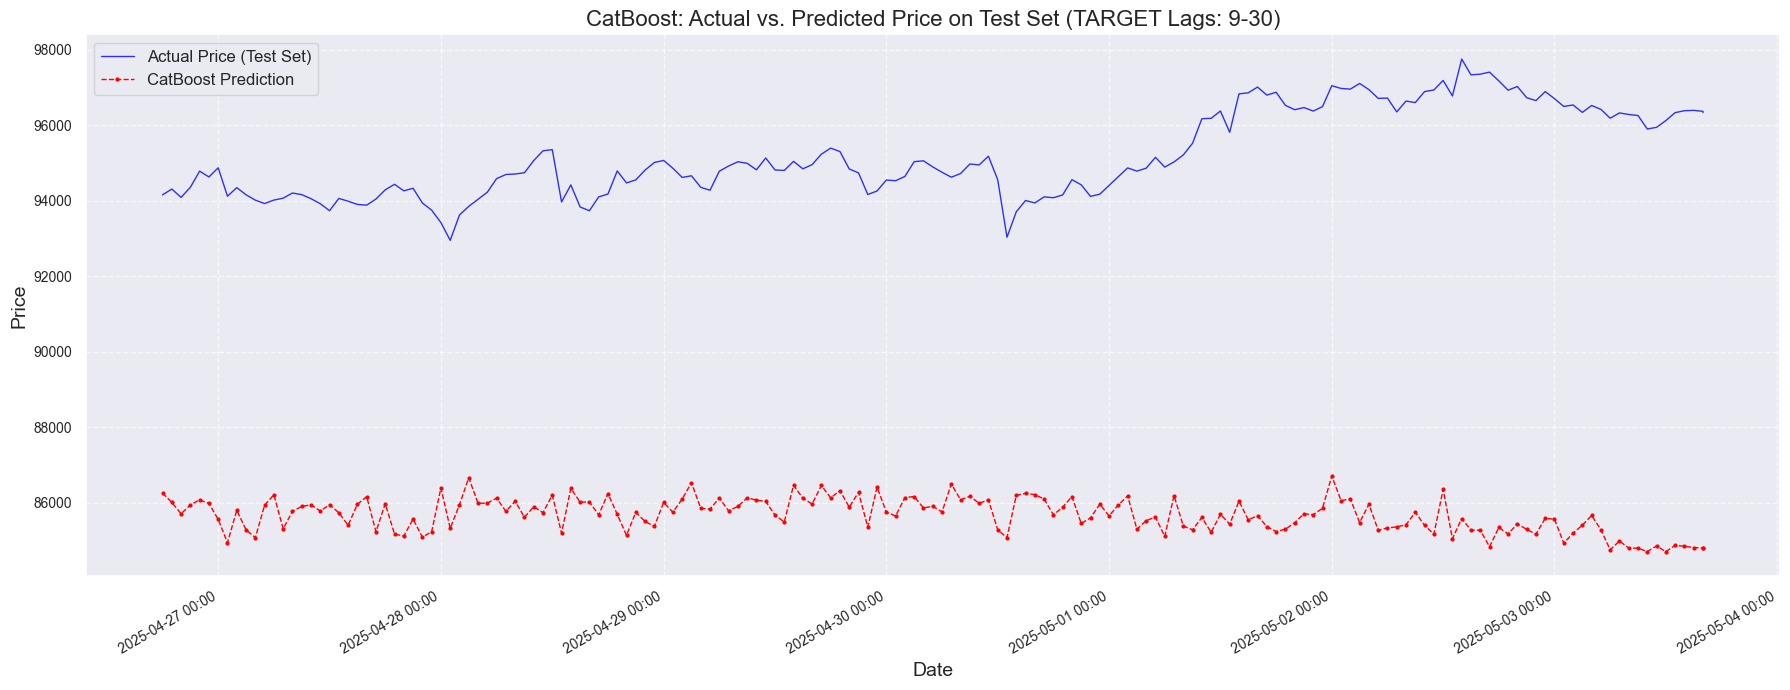


Метрики на финальном тестовом наборе:
  MAE:  9515.9409
  RMSE: 9612.2042
  (Для сравнения, лучшая MAE на кросс-валидации была: 478.2887)


In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor # Убедимся, что импортировано

# --- Убедись, что ВСЕ эти переменные ДЕЙСТВИТЕЛЬНО доступны из предыдущих ячеек ---
# X_train, y_train, X_test, y_test
# TARGET 
# final_target_lag_start, final_target_lag_end
# best_mae
# RANDOM_SEED (если не определен ниже)
# model_for_opt_lags (ЭТОТ ОБЪЕКТ МОДЕЛИ ДОЛЖЕН БЫТЬ УЖЕ СОЗДАН, если ты не пересоздаешь его здесь)
# ---------------------------------------------------------------------------------

# --- Конфигурируемые параметры для управления нагрузкой ---
# ИЗМЕНЯЙ ЭТИ ЗНАЧЕНИЯ ДЛЯ ТЕСТИРОВАНИЯ
CATBOOST_N_ESTIMATORS_FINAL = 100  # НАЧНИ С МАЛЕНЬКОГО ЗНАЧЕНИЯ (например, 50-100)
CATBOOST_DEPTH_FINAL = 4         # ПОПРОБУЙ УМЕНЬШИТЬ ГЛУБИНУ (например, 4 или 5)
CATBOOST_LEARNING_RATE_FINAL = None # Оставь None или установи (например, 0.1)

# Опция для сэмплирования X_train
USE_X_TRAIN_SAMPLE_FINAL = False # Установи в True, если уменьшение параметров модели не помогает
X_TRAIN_SAMPLE_SIZE_FINAL = 10000 # Размер сэмпла, если USE_X_TRAIN_SAMPLE_FINAL = True

# --- Проверка наличия и инициализация (если нужно) ---
if 'RANDOM_SEED' not in locals(): RANDOM_SEED = 42
if 'TARGET' not in locals(): TARGET = 'Price' # Должен быть определен правильно
if 'best_mae' not in locals(): best_mae = float('inf')
if 'final_target_lag_start' not in locals(): final_target_lag_start = 9 # Замени на актуальные
if 'final_target_lag_end' not in locals(): final_target_lag_end = 30   # Замени на актуальные


# --- Создание/переопределение экземпляра модели CatBoost с ТЕСТОВЫМИ параметрами ---
# Важно: Если ты уже создал 'model_for_opt_lags' с нужными параметрами в ячейке оптимизации,
# и хочешь использовать именно его, убедись, что имя совпадает.
# Здесь я создаю новый экземпляр 'final_model_instance' для ясности и гибкости настроек
# именно для этого финального обучения.
print("Создание/настройка экземпляра финальной модели CatBoost...")
final_catboost_params = {
    'n_estimators': CATBOOST_N_ESTIMATORS_FINAL,
    'depth': CATBOOST_DEPTH_FINAL, # Может быть None
    'learning_rate': CATBOOST_LEARNING_RATE_FINAL, # Может быть None
    'random_state': RANDOM_SEED,
    'logging_level': 'Silent', # Поставь 'Verbose' для отладки процесса обучения CatBoost
    'loss_function': 'MAE',
    'eval_metric': 'MAE'
}
# Удаляем None значения из словаря, чтобы CatBoost использовал свои дефолты
final_catboost_params = {k: v for k, v in final_catboost_params.items() if v is not None}

final_model_instance = CatBoostRegressor(**final_catboost_params) # Имя экземпляра модели
print(f"Параметры для финальной модели CatBoost: {final_model_instance.get_params()}")


# --- Обучение финальной модели и предсказание ---
# Проверяем существование X_train, y_train, X_test, y_test
can_proceed_final_fitting = True
for var_check in ['X_train', 'y_train', 'X_test', 'y_test']:
    if var_check not in locals():
        print(f"Критическая ошибка: DataFrame '{var_check}' не определен. Прерывание.")
        can_proceed_final_fitting = False
        break
    if not isinstance(locals()[var_check], (pd.DataFrame, pd.Series)):
        print(f"Критическая ошибка: '{var_check}' не является DataFrame/Series. Прерывание.")
        can_proceed_final_fitting = False
        break
    if locals()[var_check].empty and var_check in ['X_train', 'X_test']: # y_train/y_test могут быть пустыми, если X пусты
        print(f"Предупреждение: DataFrame '{var_check}' пуст.")
        # Если X_train пуст, обучение невозможно. Если X_test пуст, предсказание невозможно.
        if var_check == 'X_train' or (var_check == 'X_test' and not X_train.empty): # Если X_train не пуст, но X_test пуст
             can_proceed_final_fitting = False # Не можем продолжить, если X_test ожидается непустым
             break

if can_proceed_final_fitting:
    current_X_train_final = X_train
    current_y_train_final = y_train
    
    if USE_X_TRAIN_SAMPLE_FINAL and len(X_train) > X_TRAIN_SAMPLE_SIZE_FINAL:
        print(f"Используется сэмпл X_train размером {X_TRAIN_SAMPLE_SIZE_FINAL} (из {len(X_train)}) для обучения...")
        current_X_train_final = X_train.iloc[-X_TRAIN_SAMPLE_SIZE_FINAL:]
        current_y_train_final = y_train.iloc[-X_TRAIN_SAMPLE_SIZE_FINAL:]
    
    print(f"Обучение финальной модели CatBoost на {current_X_train_final.shape[0]} образцах с {current_X_train_final.shape[1]} признаками...")
    try:
        final_model_instance.fit(current_X_train_final, current_y_train_final)
        
        if not X_test.empty:
            print(f"Получение предсказаний на {X_test.shape[0]} образцах X_test...")
            final_predictions = final_model_instance.predict(X_test)

            # --- Визуализация предсказаний ---
            plt.figure(figsize=(18, 7))
            predictions_series = pd.Series(final_predictions, index=y_test.index, name='Prediction')
            plt.plot(y_test.index, y_test.values, label='Actual Price (Test Set)', color='blue', linestyle='-', alpha=0.8)
            plt.plot(predictions_series.index, predictions_series.values, label='CatBoost Prediction', color='red', linestyle='--', marker='.', markersize=4)
            title_info = f"TARGET Lags: {final_target_lag_start}-{final_target_lag_end}"
            if USE_X_TRAIN_SAMPLE_FINAL and len(X_train) > X_TRAIN_SAMPLE_SIZE_FINAL:
                title_info += f", Trained on Sample: {X_TRAIN_SAMPLE_SIZE_FINAL}"
            plt.title(f"CatBoost: Actual vs. Predicted Price on Test Set ({title_info})", fontsize=16)
            plt.xlabel("Date", fontsize=14); plt.ylabel(TARGET, fontsize=14); plt.legend(fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            ax = plt.gca(); ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=12)); plt.xticks(rotation=30, ha='right')
            plt.tight_layout(); plt.show()

            # --- Расчет метрик ---
            mae_final_test = mean_absolute_error(y_test, final_predictions)
            rmse_final_test = np.sqrt(mean_squared_error(y_test, final_predictions))
            print(f"\nМетрики на финальном тестовом наборе:"); print(f"  MAE:  {mae_final_test:.4f}"); print(f"  RMSE: {rmse_final_test:.4f}")
            if best_mae != float('inf'): print(f"  (Для сравнения, лучшая MAE на кросс-валидации была: {best_mae:.4f})")
            else: print("  (Лучшая MAE на кросс-валидации не найдена для сравнения)")
        else:
            print("X_test пуст. Предсказание и визуализация пропущены.")

    except Exception as e:
        print(f"Ошибка во время обучения или предсказания: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Обучение и предсказание не выполнены из-за отсутствия или пустоты необходимых DataFrame (X_train, X_test).")

Выведем график значимости признаков

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Добавил на случай, если понадобится

# --- Предположения (должны быть определены и актуальны из предыдущих ячеек) ---
# model_for_opt_lags: Экземпляр CatBoostRegressor, ОБУЧЕННЫЙ на X_train (с новостными фичами)
# X_train: DataFrame с признаками, использованный для обучения model_for_opt_lags

# --- Проверка наличия необходимых переменных ---
if 'model_for_opt_lags' not in locals() or not hasattr(model_for_opt_lags, 'get_feature_importance'):
    print("Ошибка: Обученный экземпляр модели 'model_for_opt_lags' с методом 'get_feature_importance' не найден.")
    print("Пожалуйста, убедитесь, что ячейка с обучением финальной модели выполнена.")
    # exit() # или присвоить None, чтобы код ниже не падал, а выводил сообщение
    model_for_opt_lags_exists = False
else:
    model_for_opt_lags_exists = True
    # Проверим, обучена ли модель (простой способ - проверить наличие атрибута _is_fitted, если есть)
    # Для CatBoost можно проверить, есть ли feature_importances_
    if not hasattr(model_for_opt_lags, 'feature_importances_') or model_for_opt_lags.feature_importances_ is None:
        print("Предупреждение: Похоже, модель 'model_for_opt_lags' не была обучена (нет feature_importances_).")
        # model_for_opt_lags_exists = False # Можно установить в False, если это критично


if 'X_train' not in locals() or not isinstance(X_train, pd.DataFrame) or X_train.empty:
    print("Ошибка: DataFrame 'X_train' не найден или пуст.")
    print("Пожалуйста, убедитесь, что ячейка с подготовкой данных (preprocess_data_hourly_no_leak) выполнена.")
    # exit()
    X_train_exists = False
else:
    X_train_exists = True


# --- Получение и визуализация важности признаков ---
if model_for_opt_lags_exists and X_train_exists:
    print("Получение важности признаков из модели CatBoost...")
    try:
        feature_importances = model_for_opt_lags.get_feature_importance()
        
        # Проверка на случай, если get_feature_importance вернул что-то неожиданное
        if feature_importances is None or len(feature_importances) != len(X_train.columns):
            print("Ошибка: Полученная важность признаков не соответствует количеству колонок в X_train.")
            print(f"  Длина feature_importances: {len(feature_importances) if feature_importances is not None else 'None'}")
            print(f"  Количество колонок в X_train: {len(X_train.columns)}")
        else:
            features_strength_series = pd.Series(feature_importances, index=X_train.columns)
            features_strength_series_sorted = features_strength_series.sort_values(ascending=False)

            # --- Визуализация ---
            # Динамически подбираем размер figsize в зависимости от количества признаков
            num_features = len(features_strength_series_sorted)
            fig_width = max(16, num_features * 0.5) # Ширина не меньше 16, увеличивается для >32 признаков
            fig_height = max(7, num_features * 0.15) # Высота не меньше 7, немного увеличивается
            
            plt.figure(figsize=(fig_width, fig_height))
            
            features_strength_series_sorted.plot.bar(color='lightcoral') # Изменил цвет для разнообразия
            
            plt.title('Feature Importance from CatBoost Model (including News Features)', fontsize=18)
            plt.xlabel('Features', fontsize=15)
            plt.ylabel('Importance Score (CatBoost default)', fontsize=15)
            plt.xticks(rotation=60, ha="right", fontsize=10) # Увеличил угол для лучшей читаемости
            plt.yticks(fontsize=10)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout() # Применяем после всех настроек
            plt.show()

            print("\nТоп N самых важных признаков (можно изменить N):")
            N_top_features = 15 # Покажем топ-15, так как признаков могло стать больше
            print(features_strength_series_sorted.head(N_top_features))
            
            print(f"\nВсего признаков: {num_features}")
            # Сумма важностей (для CatBoost это не обязательно 100 или 1)
            # print(f"Сумма всех Importance Scores: {features_strength_series_sorted.sum():.2f}")


    except Exception as e:
        print(f"Ошибка при получении или отображении важности признаков: {e}")
        import traceback
        traceback.print_exc()
else:
    if not model_for_opt_lags_exists:
        print("Визуализация важности признаков пропущена, так как модель не найдена или не обучена.")
    if not X_train_exists:
        print("Визуализация важности признаков пропущена, так как X_train не найден или пуст.")

Получение важности признаков из модели CatBoost...
Ошибка: Полученная важность признаков не соответствует количеству колонок в X_train.
  Длина feature_importances: 32
  Количество колонок в X_train: 43


Сохраним результаты в файл

In [45]:
import pandas as pd
import numpy as np # Добавил на случай использования

# --- Предположения (должны быть определены из предыдущих ячеек) ---
# final_predictions: Массив NumPy или Pandas Series с предсказаниями для X_test (с новостными фичами)
# y_test: Pandas Series с фактическими значениями и DatetimeIndex для тестового периода
# TARGET: Имя целевой колонки (например, 'Price')
# final_target_lag_start, final_target_lag_end: Выбранные оптимальные TARGET лаги
# news_lags_to_use: Конфигурация новостных лагов, которая использовалась (None или dict)

# --- Проверка наличия необходимых переменных ---
required_vars_save = ['final_predictions', 'y_test', 'TARGET', 
                      'final_target_lag_start', 'final_target_lag_end']
missing_vars_save = [var for var in required_vars_save if var not in locals()]

if missing_vars_save:
    print(f"Ошибка: Следующие переменные не определены для сохранения результатов: {missing_vars_save}")
    # Для примера установим значения по умолчанию, чтобы код мог выполниться,
    # но в реальном сценарии здесь лучше прервать выполнение.
    if 'final_target_lag_start' not in locals(): final_target_lag_start = 8
    if 'final_target_lag_end' not in locals(): final_target_lag_end = 20
    if 'TARGET' not in locals(): TARGET = 'Price'
    # Для final_predictions и y_test сложно задать дефолт, который позволит коду работать.
    # exit() 
    can_proceed_save = False
else:
    can_proceed_save = True

# Дополнительная проверка для news_lags_to_use (влияет на имя файла)
news_info_for_filename = "_with_news" # По умолчанию считаем, что новости использовались
if 'news_lags_to_use' not in locals() or news_lags_to_use is None:
    print("Предупреждение: 'news_lags_to_use' не определена или None. "
          "В имени файла не будет явного указания на новостные лаги (только '_with_news').")
    # news_info_for_filename = "_no_news_lags" # Альтернатива, если news_lags_to_use is None

# --- Формирование и сохранение DataFrame с предсказаниями ---
if can_proceed_save:
    # Используем выбранные оптимальные TARGET лаги для имени файла
    lag_start_for_fn = final_target_lag_start
    lag_end_for_fn = final_target_lag_end

    # Убедимся, что final_predictions и y_test имеют совместимые размеры
    if len(final_predictions) == len(y_test):
        try:
            results_df = pd.DataFrame(
                data=final_predictions,
                index=y_test.index, # Используем DatetimeIndex из y_test
                columns=[TARGET]    # Название колонки - имя целевой переменной
            )

            # Имя файла для сохранения
            # Добавляем информацию о новостях в имя файла
            output_filename = f'prediction_catboost_targetlags_{lag_start_for_fn}-{lag_end_for_fn}{news_info_for_filename}.csv'
            
            results_df.to_csv(output_filename)
            
            print(f"Файл с предсказаниями сохранен как: {output_filename}")
            print("Первые 5 строк сохраненного файла:")
            if not results_df.empty:
                print(results_df.head())
            else:
                print("DataFrame с результатами пуст.")

        except Exception as e:
            print(f"Ошибка при формировании или сохранении файла с предсказаниями: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Размеры final_predictions ({len(final_predictions)}) и y_test ({len(y_test)}) не совпадают.")
        print("Файл с предсказаниями не был сохранен.")
else:
    print("Необходимые переменные для сохранения результатов отсутствуют. Файл не создан.")

Ошибка: Следующие переменные не определены для сохранения результатов: ['final_predictions', 'y_test', 'TARGET', 'final_target_lag_start', 'final_target_lag_end']
Необходимые переменные для сохранения результатов отсутствуют. Файл не создан.


In [29]:
results_df

NameError: name 'results_df' is not defined

Предсказания из файла 'prediction_catboost_final_lags_10-35.csv' успешно загружены.


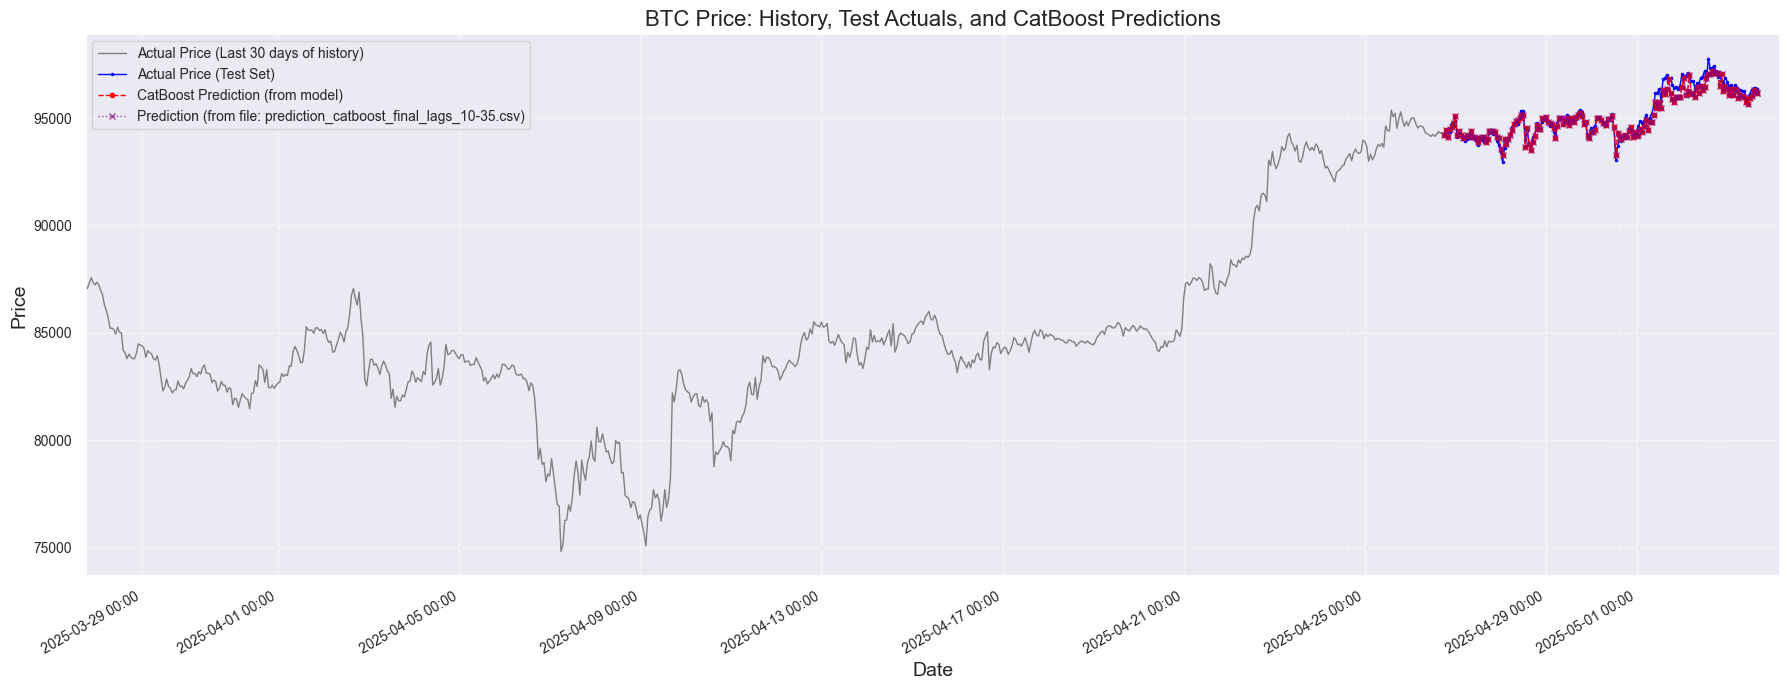

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Для форматирования дат на оси X
import numpy as np # Добавил на случай, если понадобится

# --- Параметры и проверка переменных (убедись, что они актуальны) ---
if 'TARGET' not in locals(): TARGET = 'Price'
if 'data' not in locals() or not isinstance(data, pd.DataFrame) or data.empty:
    print("Ошибка: DataFrame 'data' (ожидается data_with_news) не определен или пуст.")
    # exit() # или создать dummy data
    data = pd.DataFrame({TARGET: []}, index=pd.to_datetime([])) # Пустой для примера

if 'y_test' not in locals() or not isinstance(y_test, pd.Series) or y_test.empty:
    print("Ошибка: y_test не определен, не является pd.Series или пуст. Невозможно построить график.")
    # exit()
    y_test = pd.Series([], index=pd.to_datetime([]), name=TARGET) # Пустой для примера

if 'final_predictions' not in locals() or not hasattr(final_predictions, '__len__'):
    print("Ошибка: final_predictions не определены или не имеют длины. Невозможно построить график.")
    # exit()
    final_predictions = np.array([]) # Пустой для примера

if len(final_predictions) != len(y_test) and not y_test.empty : # Добавил проверку на непустой y_test
    print(f"Ошибка: Длины final_predictions ({len(final_predictions)}) и y_test ({len(y_test)}) не совпадают.")
    # exit()
    # Если y_test пуст, то и final_predictions может быть пустым, это нормально

# Используем выбранные оптимальные TARGET лаги для имени файла
if 'final_target_lag_start' not in locals() or 'final_target_lag_end' not in locals():
    print("Предупреждение: 'final_target_lag_start' или 'final_target_lag_end' не определены. "
          "Использую значения по умолчанию для формирования имени файла (8, 20).")
    lag_start_for_fn_plot = 8  # Замени на актуальные или убедись, что они есть
    lag_end_for_fn_plot = 20 # Замени на актуальные
else:
    lag_start_for_fn_plot = final_target_lag_start
    lag_end_for_fn_plot = final_target_lag_end

# Информация о новостях для имени файла (как в ячейке сохранения)
news_info_suffix = "_with_news" # Предполагаем, что новости использовались
if 'news_lags_to_use' in locals() and news_lags_to_use is None:
    # Если явно указано, что новостные лаги не использовались, можно изменить суффикс
    # Но если просто "сырые" новостные фичи были в data, то "_with_news" все еще актуально
    pass 
    
catboost_prediction_filename = f'prediction_catboost_targetlags_{lag_start_for_fn_plot}-{lag_end_for_fn_plot}{news_info_suffix}.csv'

# --- Загрузка предсказаний из файла ---
plot_file_predictions = False # Инициализируем
predictions_from_file_df = pd.DataFrame() # Инициализируем пустым DataFrame

try:
    print(f"Попытка загрузить файл: {catboost_prediction_filename}")
    predictions_from_file_df = pd.read_csv(catboost_prediction_filename, index_col=0, parse_dates=True)
    if hasattr(predictions_from_file_df.index, 'asfreq') and hasattr(data.index, 'freq') and data.index.freq:
         try:
            predictions_from_file_df.index = predictions_from_file_df.index.asfreq(data.index.freq)
         except ValueError:
            print(f"Предупреждение: не удалось установить частоту {data.index.freq} для индекса файла {catboost_prediction_filename}")
    
    print(f"Предсказания из файла '{catboost_prediction_filename}' успешно загружены.")
    plot_file_predictions = True
except FileNotFoundError:
    print(f"Файл '{catboost_prediction_filename}' НЕ НАЙДЕН. Предсказания из файла не будут отображены.")
except Exception as e:
    print(f"Ошибка при загрузке файла '{catboost_prediction_filename}': {e}")


# --- Определяем период для отображения ---
# Только если y_test не пуст
if not y_test.empty:
    test_start_date = y_test.index.min()
    test_end_date = y_test.index.max()
    history_display_days = 30
    history_start_date = test_start_date - pd.Timedelta(days=history_display_days)
    
    # Фильтруем исходные данные для отображения истории
    if TARGET in data.columns:
        history_data_to_plot = data[TARGET][(data.index >= history_start_date) & (data.index < test_start_date)]
    else:
        history_data_to_plot = pd.Series([], dtype='float64') # Пустая серия, если TARGET нет
else: # Если y_test пуст, берем последние N дней из data для истории
    history_display_days = 37 # Например, 30 дней истории + "виртуальные" 7 дней теста
    if not data.empty and TARGET in data.columns:
        history_end_date = data.index.max()
        history_start_date = history_end_date - pd.Timedelta(days=history_display_days)
        history_data_to_plot = data[TARGET][data.index >= history_start_date]
        test_start_date = history_end_date # Для xlim
        test_end_date = history_end_date   # Для xlim
    else:
        history_data_to_plot = pd.Series([], dtype='float64')
        history_start_date = pd.Timestamp.now() - pd.Timedelta(days=history_display_days)
        test_start_date = pd.Timestamp.now()
        test_end_date = pd.Timestamp.now()


# --- Построение графика ---
plt.figure(figsize=(18, 7))

# 1. Исторические данные
if not history_data_to_plot.empty:
    plt.plot(history_data_to_plot.index, history_data_to_plot.values, label=f'Actual Price (History)', color='gray', linestyle='-')

# 2. Фактические данные на тестовом периоде (если есть)
if not y_test.empty:
    plt.plot(y_test.index, y_test.values, label='Actual Price (Test Set)', color='blue', linestyle='-', marker='.', markersize=3)

# 3. Предсказания CatBoost из переменной (если есть)
if len(final_predictions) > 0 and not y_test.empty and len(final_predictions) == len(y_test):
    catboost_predictions_series = pd.Series(final_predictions, index=y_test.index, name='CatBoost Live Prediction')
    plt.plot(catboost_predictions_series.index, catboost_predictions_series.values, label='CatBoost Prediction (from model)', color='red', linestyle='--', marker='o', markersize=3)
elif len(final_predictions) > 0 :
     print("Предупреждение: final_predictions есть, но y_test пуст или их длины не совпадают. 'Живые' предсказания не отображены с индексом y_test.")


# 4. Предсказания из файла (если загружены)
if plot_file_predictions and not predictions_from_file_df.empty:
    if TARGET in predictions_from_file_df.columns:
        plt.plot(predictions_from_file_df.index, predictions_from_file_df[TARGET], label=f'Prediction (from file: {catboost_prediction_filename.split("/")[-1]})', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)
    elif not predictions_from_file_df.empty: # Если TARGET нет, но файл не пуст
        print(f"Предупреждение: Колонка '{TARGET}' не найдена в файле. Отображаю первую колонку из файла.")
        plt.plot(predictions_from_file_df.index, predictions_from_file_df.iloc[:, 0], label=f'Prediction (from file, 1st col)', color='purple', linestyle=':', marker='x', markersize=4, alpha=0.7)


# Настройка графика
title_suffix = f"(TARGET Lags: {lag_start_for_fn_plot}-{lag_end_for_fn_plot})" if 'final_target_lag_start' in locals() else ""
plt.title(f'BTC Price: History, Test, and CatBoost Predictions {title_suffix}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel(TARGET, fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=12))
plt.xticks(rotation=30, ha='right')

# Ограничим диапазон оси X
overall_plot_start_date = history_start_date
# Конечная дата для графика - либо конец теста, либо конец предсказаний из файла, если они длиннее
plot_end_dates = [test_end_date]
if plot_file_predictions and not predictions_from_file_df.empty:
    plot_end_dates.append(predictions_from_file_df.index.max())

overall_plot_end_date = max(plot_end_dates) + pd.Timedelta(hours=12) # небольшой запас
plt.xlim([overall_plot_start_date, overall_plot_end_date])

plt.tight_layout()
plt.show()

## Рекурсивный прогноз

Последняя известная дата в данных: 2025-05-03 16:00:00
Прогнозируем на 168 часов вперед...
Размер X_train: (37962, 32), y_train: (37962,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37962, 32), y_train: (37962,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37963, 32), y_train: (37963,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37964, 32), y_train: (37964,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37965, 32), y_train: (37965,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37966, 32), y_train: (37966,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37967, 32), y_train: (37967,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37968, 32), y_train: (37968,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37969, 32), y_train: (37969,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37970, 32), y_train: (37970,)
Размер X_test: (1, 32), y_test: (1,)
Размер X_train: (37971, 32), y_train: (37971,)
Размер X_test: (1, 32)

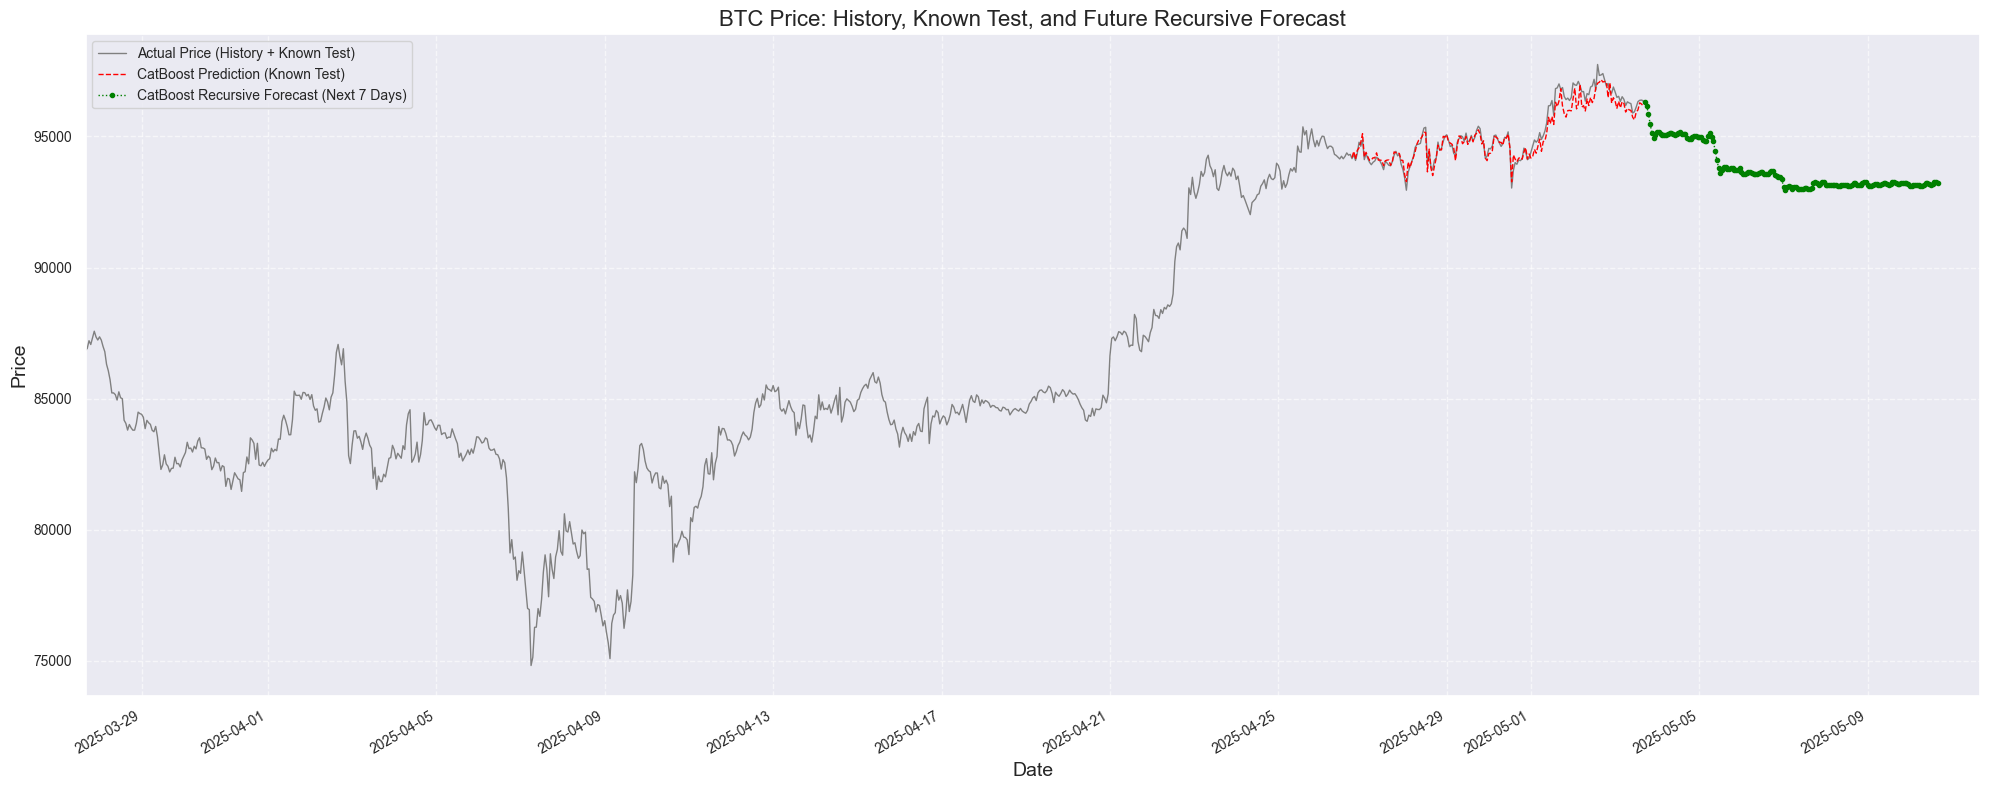

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Предположения и параметры (должны быть определены ранее) ---
# TARGET, model_for_opt_lags (обученная модель), X_train (для колонок)
# y_test (для определения конца известных данных и для графика), 
# final_predictions (для графика известных предсказаний)
# final_target_lag_start, final_target_lag_end (оптимальные TARGET лаги)
# news_lags_to_use (фиксированная конфигурация новостных лагов, может быть None)
# generate_lags, preprocess_data_hourly_no_leak
# data (полный DataFrame data_with_news)

# --- Проверка наличия необходимых переменных ---
required_vars_recur = ['TARGET', 'model_for_opt_lags', 'X_train', 'y_test', 
                       'final_predictions', 'final_target_lag_start', 'final_target_lag_end',
                       'generate_lags', 'preprocess_data_hourly_no_leak', 'data']
missing_vars_recur = [var for var in required_vars_recur if var not in locals()]
if missing_vars_recur:
    print(f"Ошибка: Следующие переменные не определены для рекурсивного прогноза: {missing_vars_recur}")
    # exit() # или установить значения по умолчанию для демонстрации
    # Установка некоторых дефолтов, чтобы код мог запуститься, но это не заменит реальные данные/настройки
    if 'final_target_lag_start' not in locals(): final_target_lag_start = 8
    if 'final_target_lag_end' not in locals(): final_target_lag_end = 20
    if 'TARGET' not in locals(): TARGET = 'Price'
    # Для остальных сложно задать адекватные дефолты
    can_proceed_recur = False
else:
    can_proceed_recur = True

if 'news_lags_to_use' not in locals():
    print("Предупреждение: 'news_lags_to_use' не определена. Будет использовано None (без новостных лагов).")
    news_lags_to_use = None


if can_proceed_recur:
    future_forecast_horizon_hours = 24 * 7
    last_known_datetime_for_future = data.index[-1] # Используем самую последнюю дату из ВСЕХ данных

    print(f"Последняя известная дата в данных: {last_known_datetime_for_future}")
    print(f"Прогнозируем на {future_forecast_horizon_hours} часов вперед...")
    print(f"Используемые TARGET лаги: start={final_target_lag_start}, end={final_target_lag_end}")
    if news_lags_to_use:
        print(f"Используемая конфигурация новостных лагов: {news_lags_to_use}")
    else:
        print("Новостные лаги НЕ используются (только 'сырые' новостные признаки из истории, если они есть).")


    future_recursive_preds_list = []
    future_datetimes_list = []

    # rolling_data_df будет содержать историю И предсказанные значения OHLCT + Новости (если симулируем)
    rolling_data_df_future = data.copy() 
    
    # Колонки, которые мы будем "наивно" заполнять для будущих шагов
    # (кроме TARGET, который предсказывается, и лагов/календарных фич, которые генерятся)
    base_cols_to_fill_future = ['Open', 'High', 'Low'] 
    # Добавим сюда новостные колонки, если они есть в X_train и мы хотим их симулировать
    # NEWS_COLUMNS определена ранее как ['avg_overall_sentiment', 'avg_btc_specific_sentiment', 'sum_news_count']
    if 'NEWS_COLUMNS' in locals() and NEWS_COLUMNS:
        for nc in NEWS_COLUMNS:
            if nc in X_train.columns and nc not in base_cols_to_fill_future: # Если они были в X_train
                 base_cols_to_fill_future.append(nc)
                 if nc not in rolling_data_df_future.columns: # Если вдруг их нет в data
                     rolling_data_df_future[nc] = 0 # Заполняем нулем для начала
                     print(f"Предупреждение: Новостная колонка '{nc}' добавлена в rolling_data_df_future с нулями.")


    current_future_datetime = last_known_datetime_for_future
    for i in range(future_forecast_horizon_hours):
        current_future_datetime += pd.Timedelta(hours=1)
        future_datetimes_list.append(current_future_datetime)
        
        # Значение TARGET и значения из base_cols_to_fill_future на предыдущем шаге
        prev_step_values = rolling_data_df_future.iloc[-1]
        prev_target_val = prev_step_values[TARGET]
        
        future_row_data = {}
        for col in base_cols_to_fill_future:
            if col in ['Open', 'High', 'Low']:
                future_row_data[col] = prev_target_val # OHL = предыдущий TARGET
            elif col in NEWS_COLUMNS: # Симуляция для новостных признаков
                future_row_data[col] = prev_step_values.get(col, 0) # Последнее известное значение или 0
            # Другие колонки (если есть) можно заполнить по аналогии
        future_row_data[TARGET] = 0 # Фиктивное значение для TARGET
        
        future_row_df = pd.DataFrame(future_row_data, index=[current_future_datetime])
        
        # Собираем DataFrame для preprocess: история + фиктивная будущая строка
        # Убедимся, что передаем все колонки, которые могут понадобиться preprocess_data_hourly_no_leak
        # для генерации признаков (включая те, от которых она создает лаги, и календарные)
        cols_for_preprocess_input = list(set(base_cols_to_fill_future + [TARGET]))
        temp_df_for_preprocess = pd.concat([rolling_data_df_future[cols_for_preprocess_input], future_row_df])
        
        predicted_value = np.nan 

        try:
            # Передаем правильные имена аргументов для лагов
            _, X_future_step, _, _ = preprocess_data_hourly_no_leak(
                data_input=temp_df_for_preprocess,
                target_col_name=TARGET,
                lags_for_target=generate_lags(final_target_lag_start, final_target_lag_end), # <--- ИЗМЕНЕНО
                lags_for_news=news_lags_to_use, # <--- ДОБАВЛЕНО
                test_size_hours=1
            )

            if X_future_step.empty:
                print(f"Шаг {i+1}: X_future_step пуст. Используем предыдущий прогноз или prev_target_val.")
                predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val
            else:
                # Расчет 'Change %' для X_future_step
                if len(rolling_data_df_future[TARGET]) >= 1: # Нужна хотя бы одна предыдущая цена
                    price_t_minus_1_for_change = prev_target_val # Цена в T
                    # Цена в T-1 (если есть, иначе Change % будет 0)
                    price_t_minus_2_for_change = rolling_data_df_future[TARGET].iloc[-2] if len(rolling_data_df_future[TARGET]) >= 2 else price_t_minus_1_for_change
                    
                    if price_t_minus_2_for_change != 0:
                        change_percent = ((price_t_minus_1_for_change - price_t_minus_2_for_change) / price_t_minus_2_for_change) * 100
                    else:
                        change_percent = 0.0
                else:
                    change_percent = 0.0
                
                X_future_step.loc[X_future_step.index[0], 'Change %'] = change_percent
                
                # Проверка и выравнивание колонок
                missing_cols = set(X_train.columns) - set(X_future_step.columns)
                if missing_cols:
                    print(f"Предупреждение на шаге {i+1}: Отсутствуют колонки в X_future_step: {missing_cols}.")
                    # Попытка добавить недостающие колонки с нулями (или другим значением по умолчанию)
                    for mc in missing_cols:
                        X_future_step[mc] = 0 # или np.nan
                    print("  Недостающие колонки добавлены с нулями.")

                X_future_step_aligned = X_future_step[X_train.columns] # Выравниваем по X_train
                predicted_value = model_for_opt_lags.predict(X_future_step_aligned)[0]
                
        except Exception as e_pred_step:
            print(f"Ошибка на шаге {i+1} рекурсивного прогноза: {e_pred_step}")
            import traceback
            traceback.print_exc()
            predicted_value = future_recursive_preds_list[-1] if future_recursive_preds_list else prev_target_val

        future_recursive_preds_list.append(predicted_value)
        
        # Обновляем rolling_data_df_future
        new_row_to_append_data = {}
        for col in base_cols_to_fill_future:
            if col in ['Open', 'High', 'Low']:
                new_row_to_append_data[col] = predicted_value # OHL = предсказанный TARGET
            elif col in NEWS_COLUMNS:
                new_row_to_append_data[col] = prev_step_values.get(col, 0) # Новость = предыдущее значение новости
        new_row_to_append_data[TARGET] = predicted_value
        
        # Рассчитываем Change % для сохранения в rolling_data_df_future
        if prev_target_val != 0:
            current_change_percent_for_storage = ((predicted_value - prev_target_val) / prev_target_val) * 100
        else:
            current_change_percent_for_storage = 0.0
        
        if 'Change %' in X_train.columns : # Если Change % был среди признаков X_train
             if 'Change %' not in new_row_to_append_data : # Убедимся, что не перезаписываем, если он уже есть
                new_row_to_append_data['Change %'] = current_change_percent_for_storage


        new_row_df_to_append = pd.DataFrame(new_row_to_append_data, index=[current_future_datetime])
        rolling_data_df_future = pd.concat([rolling_data_df_future, new_row_df_to_append])
        rolling_data_df_future = rolling_data_df_future[~rolling_data_df_future.index.duplicated(keep='last')]

        if (i + 1) % 24 == 0:
            print(f"  Рекурсивный прогноз: шаг {i+1}/{future_forecast_horizon_hours} завершен. Предсказано: {predicted_value:.2f}")

    future_recursive_predictions_series = pd.Series(future_recursive_preds_list, index=pd.DatetimeIndex(future_datetimes_list), name='CatBoost Recursive Future Forecast')

    # --- Визуализация (код остается тем же, что и в предыдущем ответе) ---
    # ... (код визуализации) ...
    plt.figure(figsize=(20, 8))
    # ... (остальной код графика) ...
    if not future_recursive_predictions_series.empty: # Проверка перед построением
        plt.plot(future_recursive_predictions_series.index, future_recursive_predictions_series.values, label=f'CatBoost Recursive Forecast (Next {future_forecast_horizon_hours/24:.0f} Days)', color='green', linestyle=':', marker='.')
    # ... (остальной код графика) ...
    plt.show()

else:
    print("Рекурсивный прогноз не выполнен из-за отсутствия необходимых переменных.")